# Chapter 10
## Building Univariate Time Series Models Using Statistical Methods


# ---START: Technical Requirements---


In [4]:
# in colab statsmodels is version 0.10.2
# you will need to run the following to update it to 0.13.2
# the recipe uses 0.13.2

#!pip install statsmodels -U

In [5]:
import statsmodels
import pandas as pd

print(f'statsmodels: {statsmodels.__version__}')
print(f'pandas: {pd.__version__}')

statsmodels: 0.14.4
pandas: 2.1.4


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

from statsmodels.tsa.api import (kpss, adfuller, 
                                 seasonal_decompose, STL)
from statsmodels.tools.eval_measures import rmspe, rmse
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from itertools import product
import statsmodels as sm
from pathlib import Path


warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [12, 5]  
plt.style.use('grayscale')

In [3]:
###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [12, 5]   ##
#plt.rcParams['figure.dpi'] = 100          ## use 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=14)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################

**Check core library versions used in the recipe**
* if using **Colab** ensure the versions are the same. If needed to update use
```shell
!pip install <library_name> -U
```

In [5]:
import matplotlib 
import scipy 
import sklearn

print(f'''
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
numpy -> {np.__version__}
scipy -> {scipy.__version__}
statsmodels -> {sm.__version__}
sklearn -> {sklearn.__version__}
''')


Matplotlib -> 3.8.3
pandas -> 2.2.1   
numpy -> 1.26.4
scipy -> 1.12.0
statsmodels -> 0.14.1
sklearn -> 1.4.1.post1



In [7]:
life_file = Path('../../datasets/Ch10/life_expectancy_birth.csv')
milk_file = Path('../../datasets/Ch10/milk_production.csv')

life = pd.read_csv(life_file, 
                   index_col='year',
                   parse_dates=True,
                   skipfooter=1)

milk = pd.read_csv(milk_file, 
                   index_col='month', 
                   parse_dates=True)

In [7]:
life.shape

(59, 1)

In [8]:
milk.shape

(168, 1)

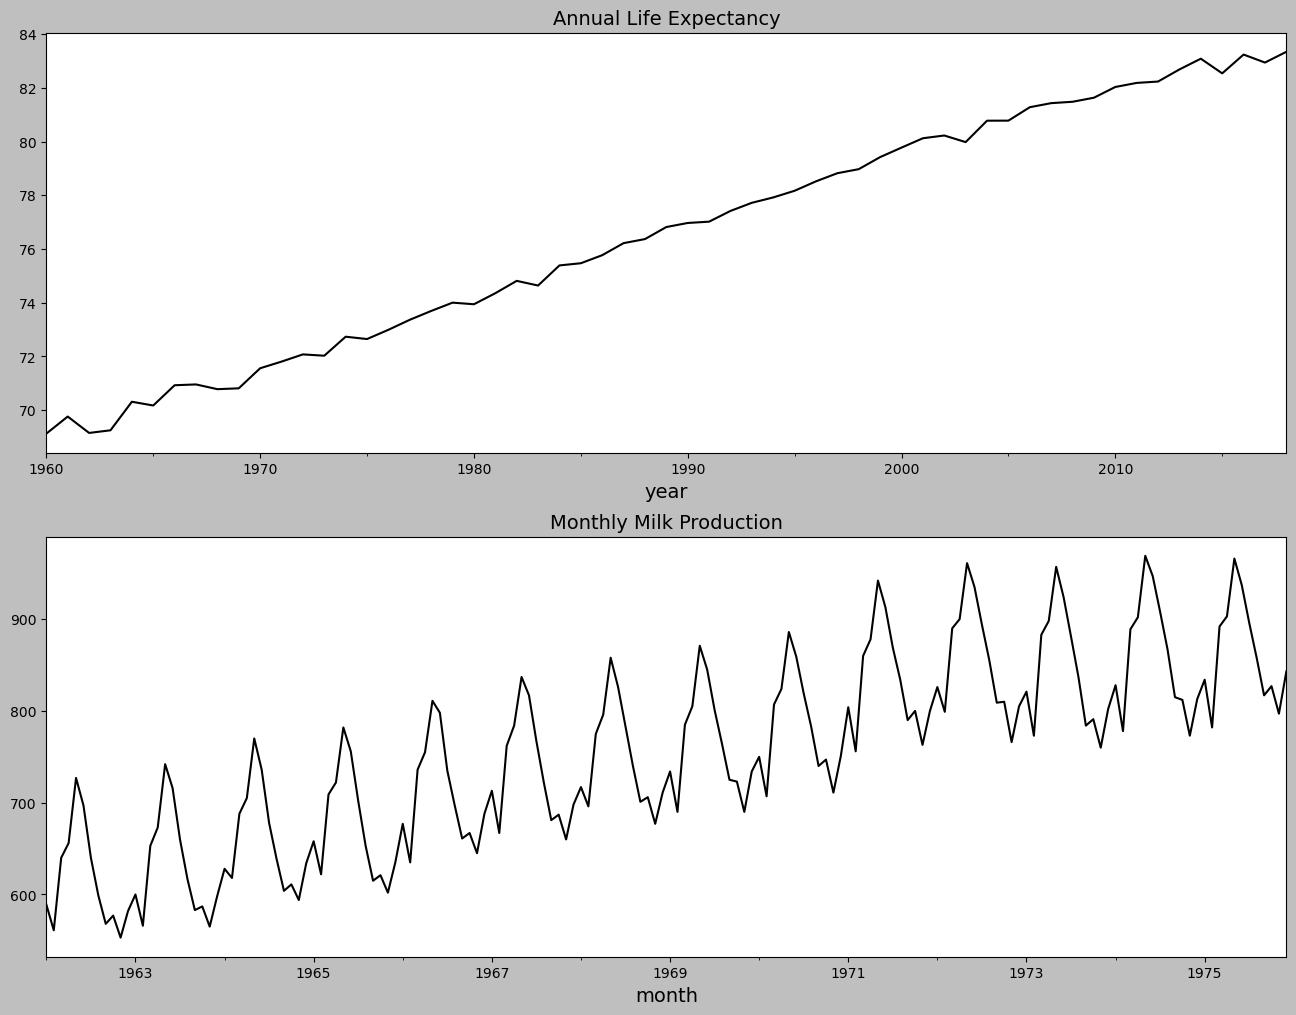

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(16, 12))
life.plot(title='Annual Life Expectancy', 
                        legend=False, ax=ax[0])
milk.plot(title='Monthly Milk Production', 
                        legend=False, ax=ax[1]);

# plt.savefig('images/fig_10.1.png', bbox_inches='tight', dpi=300)

In [8]:
def split_data(data, test_split):
    l = len(data)
    t_idx = round(l*(1-test_split))
    train, test = data[ : t_idx], data[t_idx : ]
    print(f'train: {len(train)} , test: {len(test)}')
    return train, test

In [9]:
test_split = 0.15
milk_train, milk_test = split_data(milk, test_split)
life_train, life_test = split_data(life, test_split)

train: 143 , test: 25
train: 50 , test: 9


In [12]:
def check_stationarity(df):
    results = adfuller(df)[1:3]
    s = 'Non-Stationary'
    if results[0] < 0.05:
        s = 'Stationary'
    print(f"'{s}\t p-value:{results[0]} \t lags:{results[1]}")
    return (s, results[0])

In [13]:
# Old Function
def get_best_model(score, c='AIC'):
    initial_score = score[1][c]
    best_model = 0
    for k,v in score.items():
        if v[c] < initial_score:
            initial_score = v[c]
            best_model = k
    print(f'Best model: {best_model} with lowest {c} score: {initial_score}')
    return score[best_model]['model']

In [14]:
def get_best_model(score, criterion='AIC'):
    sorted_scores = sorted(score.items(), 
                           key=lambda item: item[1][criterion])

    best_model = sorted_scores[0]['model']

    return best_model

In [15]:
# Updated new function
def get_top_models_df(scores, criterion='AIC', top_n=5):
    sorted_scores = sorted(scores.items(), 
                           key=lambda item: item[1][criterion])
    
    top_models = sorted_scores[:top_n]

    data = [v for k, v in top_models]
    df = pd.DataFrame(data)
    
    df['model_id'] = [k for k, v in top_models]
    df.set_index('model_id', inplace=True)

    return df

In [16]:
def plot_forecast(model, start, train, test):
    forecast = pd.DataFrame(model.forecast(test.shape[0]), 
                            index=test.index)
    ax = train.loc[start:].plot(style='--')
    test.plot(ax=ax)
    forecast.plot(ax=ax, style = '-.')
    ax.legend(['orig_train', 'orig_test', 'forecast'])
    # plt.show()
    return ax

In [17]:
def combinator(items, r=1):
    combo = [i for i in product(*items, repeat=r)]
    return combo

# Recipe 1. Plotting ACF and PACF

<Axes: xlabel='year'>

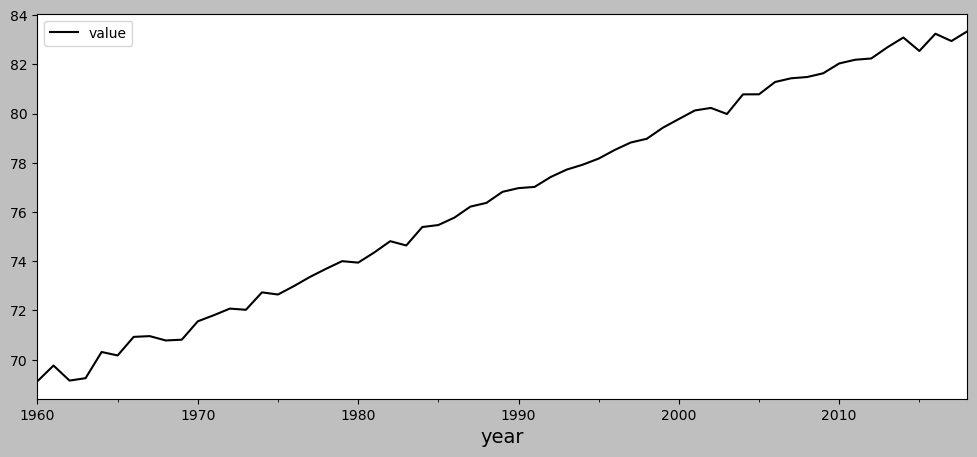

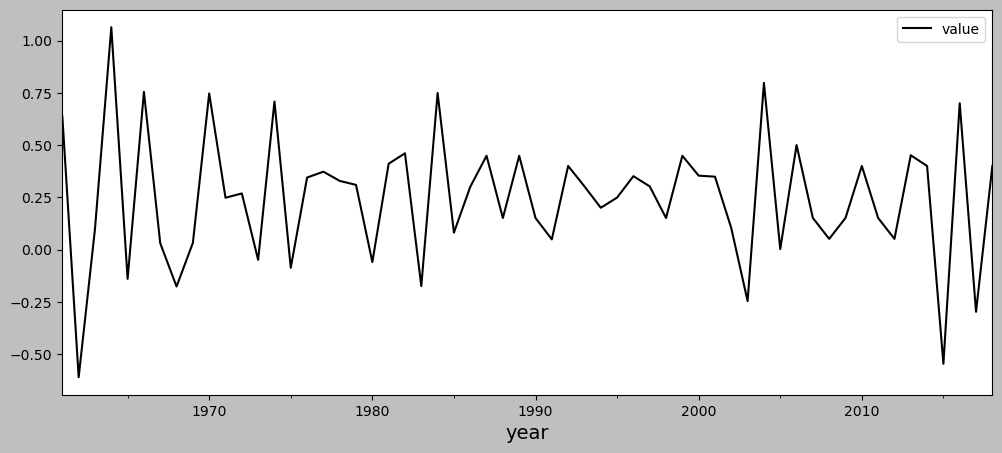

In [18]:
# plt.rcParams["figure.figsize"] = [16, 4]
life.plot()
life_diff = life.diff().dropna()
life_diff.plot()

In [19]:
check_stationarity(life_diff)

'Stationary	 p-value:1.5562189676002793e-14 	 lags:1


('Stationary', 1.5562189676002793e-14)

In [20]:
len(life)

59

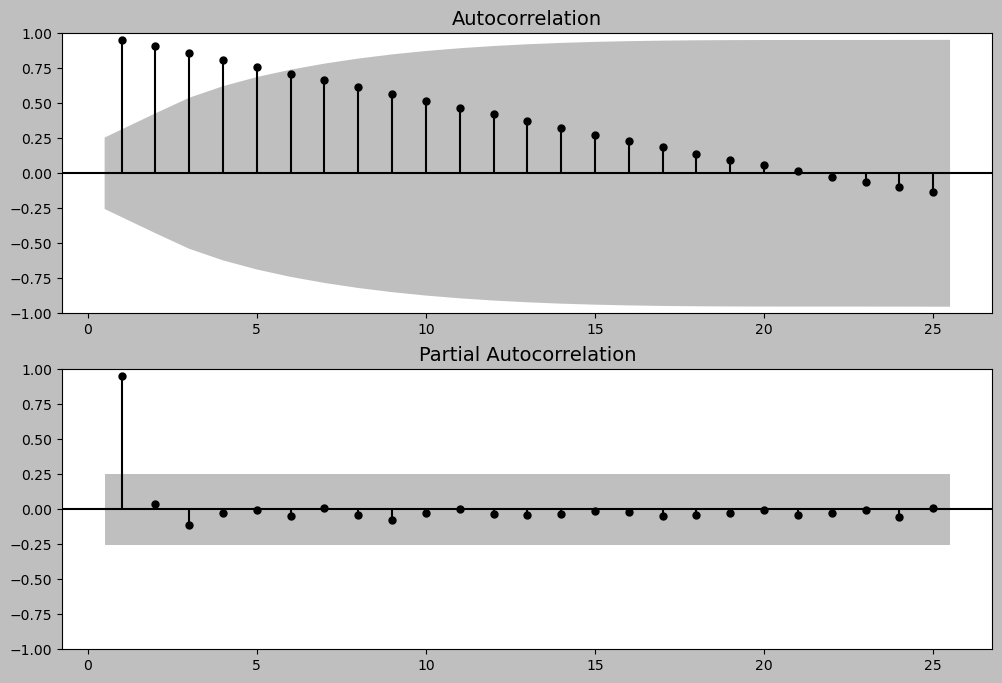

In [21]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(life, lags=25,zero=False, ax=ax[0])
plot_pacf(life, lags=25, zero=False, ax=ax[1]);

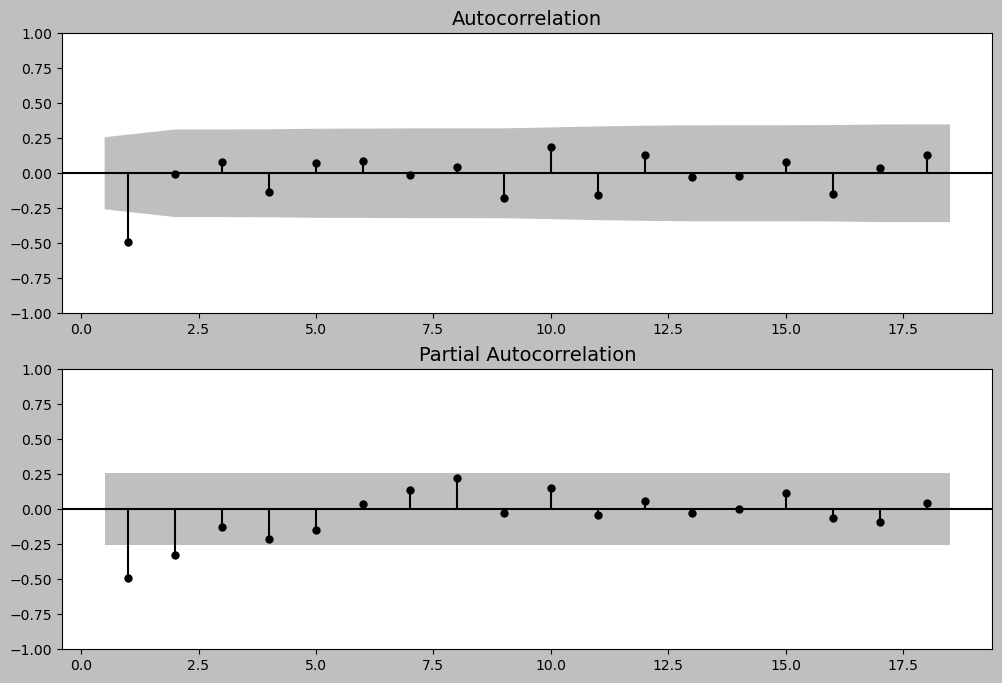

In [22]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(life_diff, zero=False, ax=ax[0])
plot_pacf(life_diff, zero=False, ax=ax[1]);
#plt.savefig('images/fig_10.2.png', bbox_inches='tight', dpi=300)

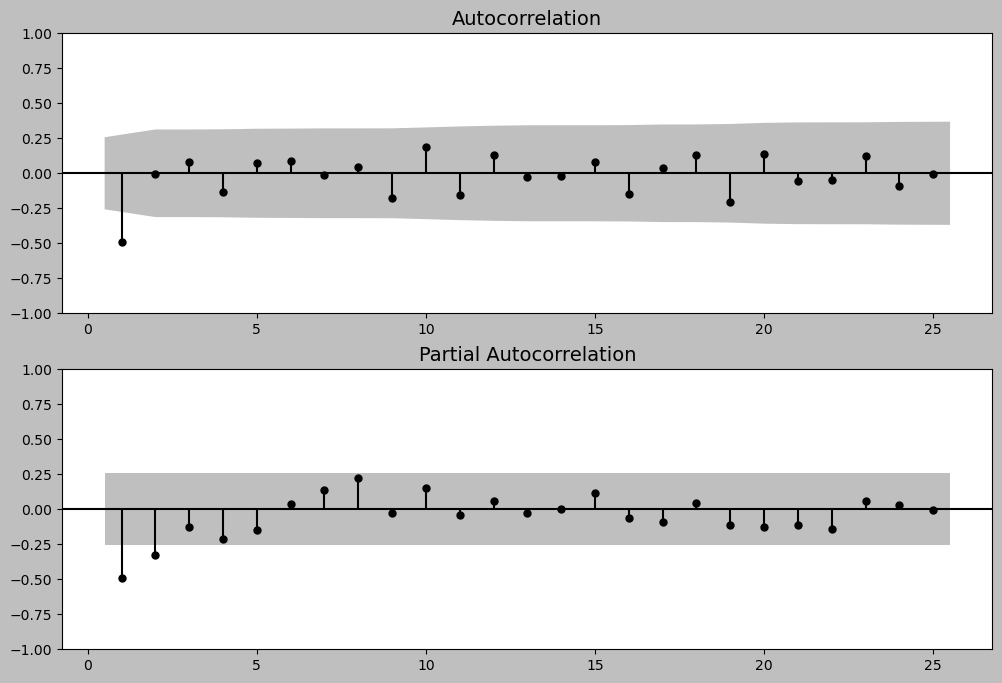

In [23]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(life_diff, lags=25, zero=False, ax=ax[0])
plot_pacf(life_diff, lags=25,  zero=False, ax=ax[1]);

<Axes: xlabel='month'>

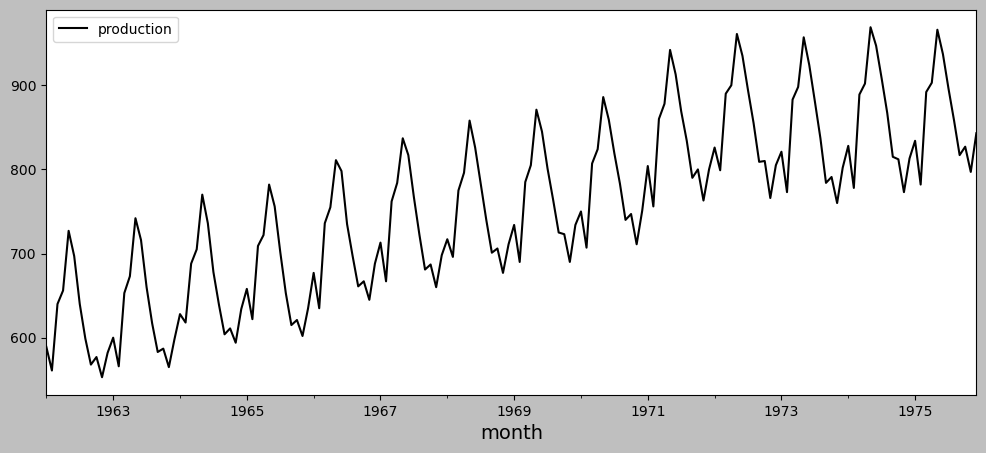

In [24]:
milk.plot()

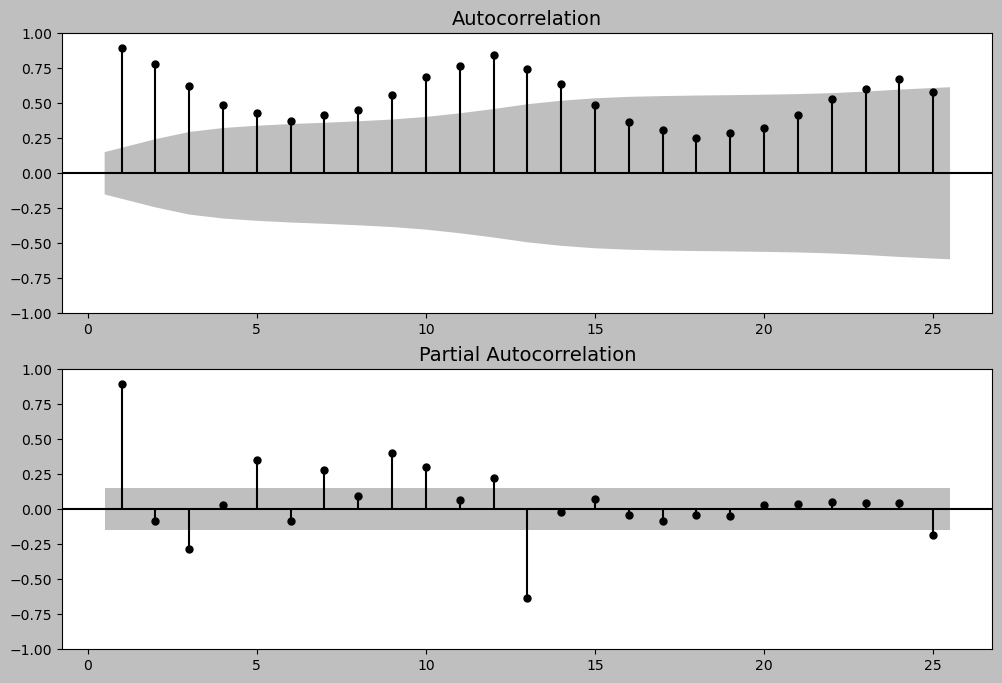

In [25]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(milk, lags=25,zero=False, ax=ax[0])
plot_pacf(milk, lags=25, zero=False, ax=ax[1]);

In [26]:
milk_diff_12 = milk.diff(12).dropna()

In [27]:
check_stationarity(milk_diff_12)

'Non-Stationary	 p-value:0.1607988052771132 	 lags:12


('Non-Stationary', 0.1607988052771132)

In [28]:
milk_diff_12_1 = milk.diff(12).diff(1).dropna()
check_stationarity(milk_diff_12_1)

'Stationary	 p-value:1.8654234318790463e-05 	 lags:11


('Stationary', 1.8654234318790463e-05)

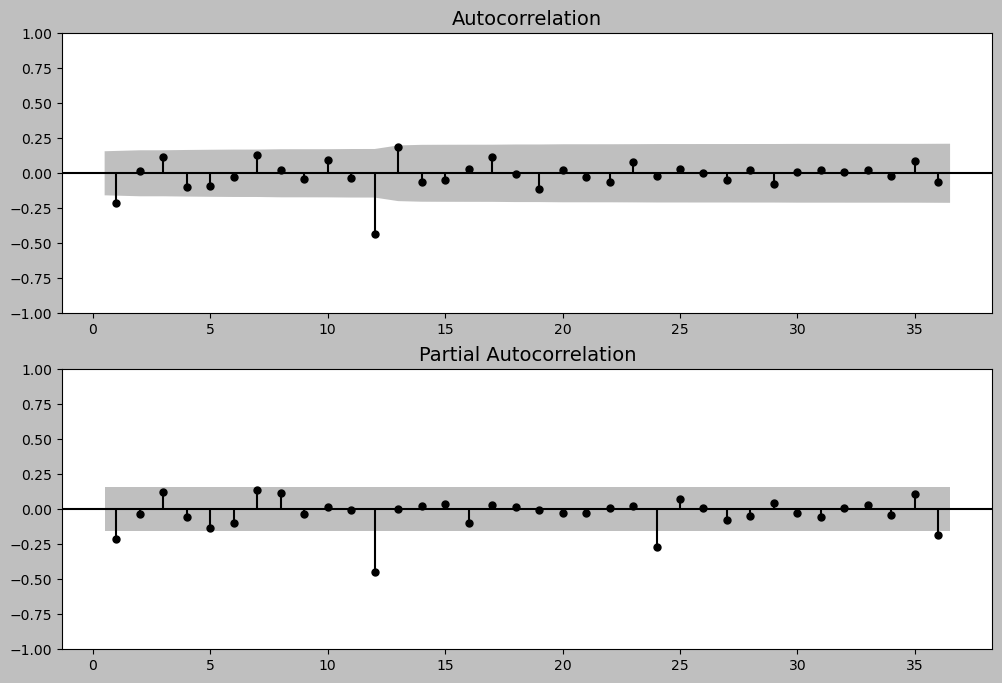

In [29]:
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(milk_diff_12_1, zero=False, ax=ax[0], lags=36)
plot_pacf(milk_diff_12_1, zero=False, ax=ax[1], lags=36)
# plt.savefig('images/fig_10.3.png', bbox_inches='tight', dpi=300)
plt.show()

## There is more

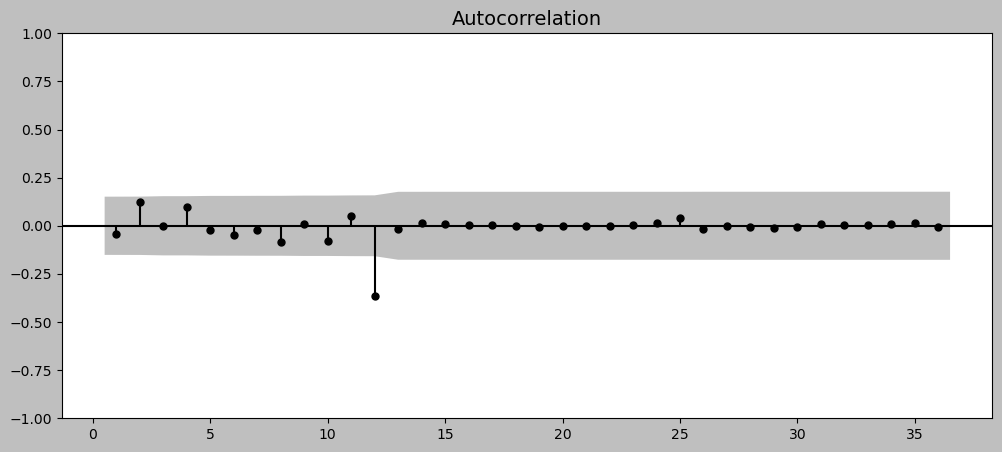

In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(milk, order=(0,1,1),
                seasonal_order=(0,1,1, 12)).fit(disp=False)
plot_acf(model.resid, zero=False, lags=36);

<Axes: xlabel='month'>

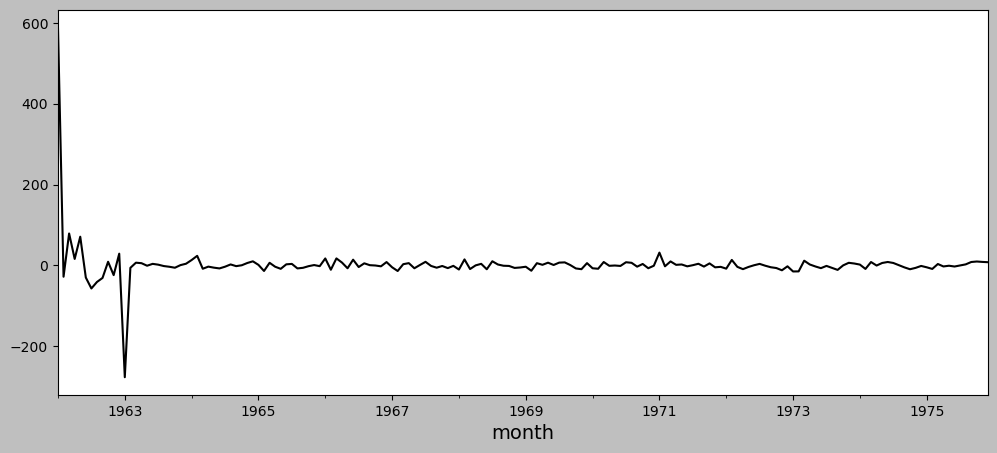

In [31]:
model.resid.plot()

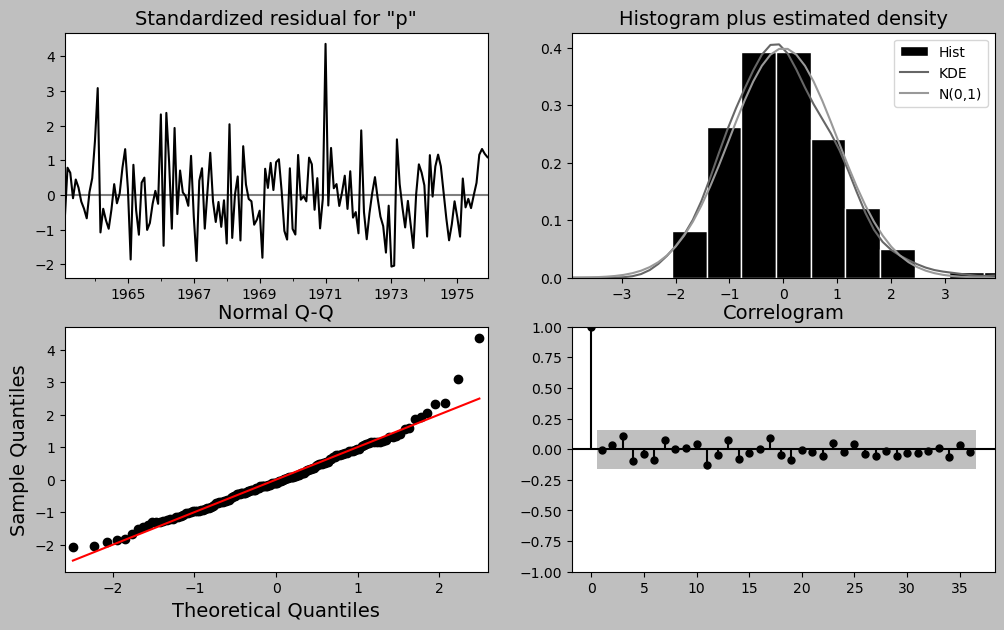

In [32]:
model.plot_diagnostics(figsize=(12,7), lags=36);

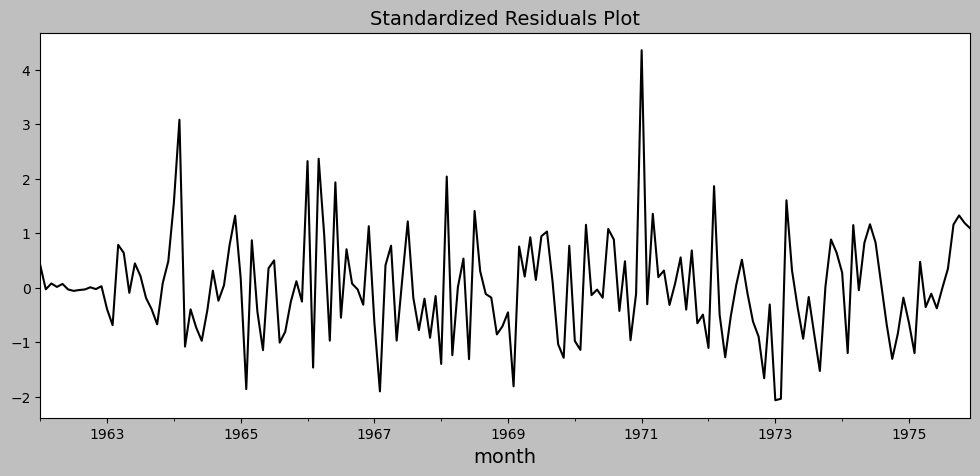

In [33]:
pd.DataFrame(model.standardized_forecasts_error.ravel(), 
             index=milk.index).plot(title='Standardized Residuals Plot', 
                                    legend=False);

# Recipe 2. Forecasting Univariate Time Series Data with Exponential Smoothing

In [34]:
from statsmodels.tsa.api import (ExponentialSmoothing, 
                                SimpleExpSmoothing, 
                                Holt)

In [35]:
trend = ['add', 'mul']
damped = [True, False]
life_ex_comb = combinator([trend, damped])
life_ex_comb

[('add', True), ('add', False), ('mul', True), ('mul', False)]

In [36]:
train = life_train.values.ravel()
y = life_test.values.ravel()
score = {}
for i, (t, dp) in enumerate(life_ex_comb):
    exp = ExponentialSmoothing(train, 
                     trend=t, 
                     damped_trend=dp,
                     seasonal=None)
    model = exp.fit(use_brute=True, optimized=True)    
    y_hat = model.forecast(len(y))
    score[i] = {'trend':t, 
                'damped':dp,
                'AIC':model.aic,
                'BIC':model.bic, 
                'AICc':model.aicc, 
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': model}

In [37]:
model_eval = get_top_models_df(score, 'AIC', top_n=5)

In [38]:
model_eval.iloc[:, 0:-1]

,trend,damped,AIC,BIC,AICc,RMSPE,RMSE,MAPE
model_id,,,,,,,,
1,add,False,-137.030602,-129.382510,-135.077113,0.067729,0.561346,0.005567
3,mul,False,-136.344215,-128.696123,-134.390727,0.070529,0.584592,0.005835
2,mul,True,-134.829825,-125.269710,-132.163158,0.064576,0.535157,0.005268
0,add,True,-133.771858,-124.211743,-131.105192,0.051100,0.423411,0.003975


In [39]:
top_model = model_eval.iloc[0,-1]
top_model.summary()

Dep. Variable:,endog,No. Observations:,50
Model:,ExponentialSmoothing,SSE,2.749
Optimized:,True,AIC,-137.031
Trend:,Additive,BIC,-129.383
Seasonal:,None,AICC,-135.077
Seasonal Periods:,None,Date:,"Thu, 18 Apr 2024"
Box-Cox:,False,Time:,20:19:45
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.1621958,alpha,True
smoothing_trend,0.1621958,beta,True


In [40]:
top_model.params_formatted

,name,param,optimized
smoothing_level,alpha,0.162196,True
smoothing_trend,beta,0.162196,True
initial_level,l.0,68.748482,True
initial_trend,b.0,0.242227,True


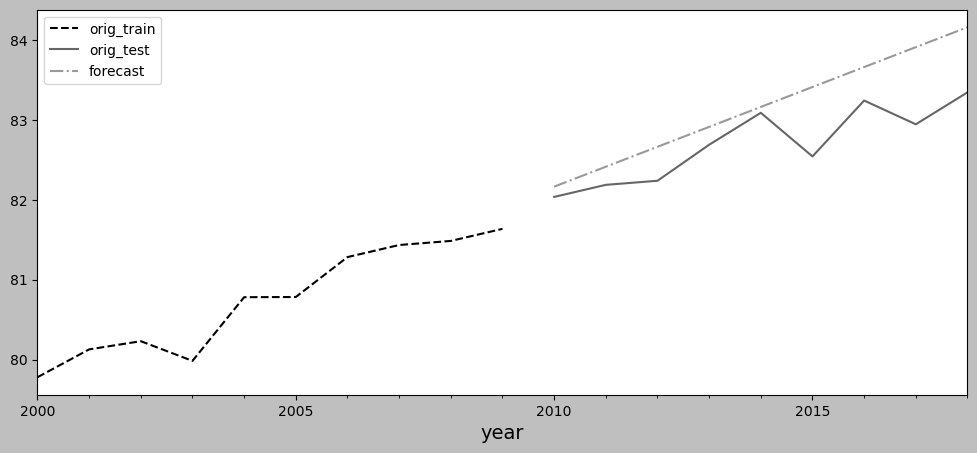

In [41]:
plot_forecast(top_model, '2000', life_train, life_test);
#plt.savefig('images/fig_10.6.png', bbox_inches='tight', dpi=300)

In [42]:
#plt.savefig('images/fig_10.6.png', bbox_inches='tight', dpi=300)

In [43]:
trend , damped= ['add', 'mul'], [True, False] 
seasonal, periods = ['add' , 'mul'], [4, 6, 12]
milk_exp_comb = combinator([trend, damped, seasonal, periods])

In [44]:
len(milk_exp_comb)

24

In [45]:
train = milk_train.values.ravel()
y = milk_test.values.ravel()
milk_model_scores = {}
for i, (t, dp, s, sp) in enumerate(milk_exp_comb):
    exp = ExponentialSmoothing(train, 
                        trend=t, 
                        damped_trend=dp,
                        seasonal=s,
                        seasonal_periods=sp)
    model = exp.fit(use_brute=True, optimized=True)    
    y_hat = model.forecast(len(y))
    score[i] = {'trend':t,
                'damped':dp,
                'AIC':model.aic,
                'BIC':model.bic, 
                'AICc': model.aicc,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': model}

In [46]:
model_eval = get_top_models_df(score, 'AIC', top_n=5)
model_eval.iloc[:, 0:-1]

,trend,damped,AIC,BIC,AICc,RMSPE,RMSE,MAPE
model_id,,,,,,,,
8,add,False,593.713880,641.119394,599.230009,0.148824,12.770388,0.011726
20,mul,False,594.622962,642.028476,600.139091,0.171995,14.763068,0.013983
2,add,True,595.561687,645.930046,601.740549,0.130059,11.058375,0.010327
11,add,False,614.895716,662.301231,620.411845,0.220577,19.858544,0.017100
23,mul,False,615.505981,662.911495,621.022110,0.246958,22.181074,0.019707


In [47]:
top_model = model_eval.iloc[0,-1]
top_model.summary()

Dep. Variable:,endog,No. Observations:,143
Model:,ExponentialSmoothing,SSE,7265.655
Optimized:,True,AIC,593.714
Trend:,Additive,BIC,641.119
Seasonal:,Additive,AICC,599.230
Seasonal Periods:,12,Date:,"Thu, 18 Apr 2024"
Box-Cox:,False,Time:,20:19:47
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6859230,alpha,True
smoothing_trend,3.8601e-10,beta,True


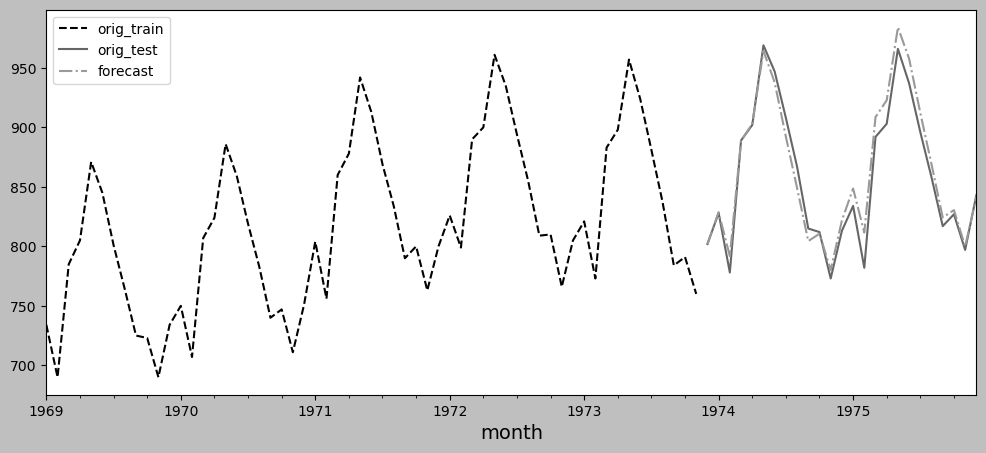

In [48]:
plot_forecast(top_model, '1969', milk_train, milk_test);
# plt.savefig('images/fig_10.8.png', bbox_inches='tight', dpi=300)

## There is more

In [49]:
model = ExponentialSmoothing(train, 
                        seasonal_periods=12)

In [50]:
model = model.fit()

In [51]:
model.summary()

Dep. Variable:,endog,No. Observations:,143
Model:,ExponentialSmoothing,SSE,283570.547
Optimized:,True,AIC,1089.709
Trend:,None,BIC,1095.635
Seasonal:,None,AICC,1089.999
Seasonal Periods:,None,Date:,"Thu, 18 Apr 2024"
Box-Cox:,False,Time:,20:19:47
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.9975389,alpha,True
initial_level,588.11243,l.0,True


In [ ]:
from darts.models import ExponentialSmoothing, StatsForecastAutoETS
from darts import TimeSeries

In [ ]:
import darts
darts.__version__

In [54]:
model = ExponentialSmoothing(seasonal_periods=12)
ts = TimeSeries.from_dataframe(milk.reset_index(), 
                                    time_col='month', value_cols='production', freq='MS')
train, test = split_data(ts, 0.15)

train: 143 , test: 25


In [55]:
modelets = StatsForecastAutoETS(season_length=12)
modelets.fit(train)

StatsForecastAutoETS(add_encoders=None, season_length=12)

In [56]:
etsforecast = modelets.predict(len(test))

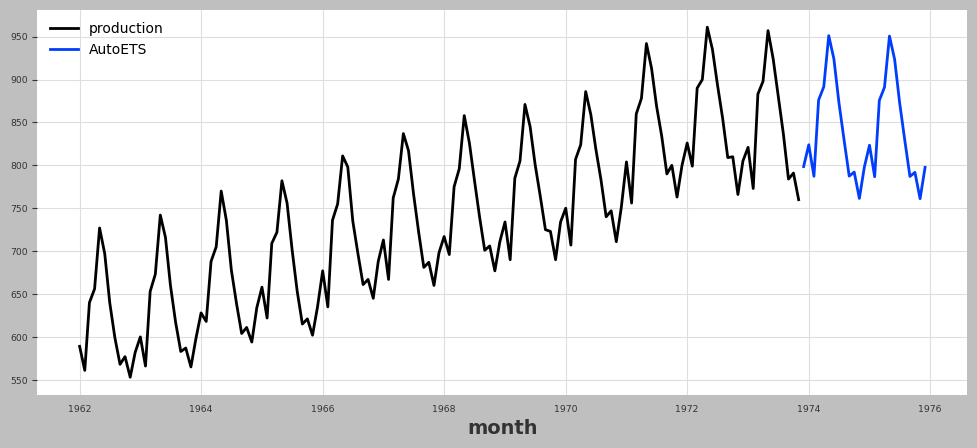

In [57]:
train.plot()
etsforecast.plot(label='AutoETS');

In [58]:
model.fit(train)
forecast = model.predict(len(test), num_samples=100)

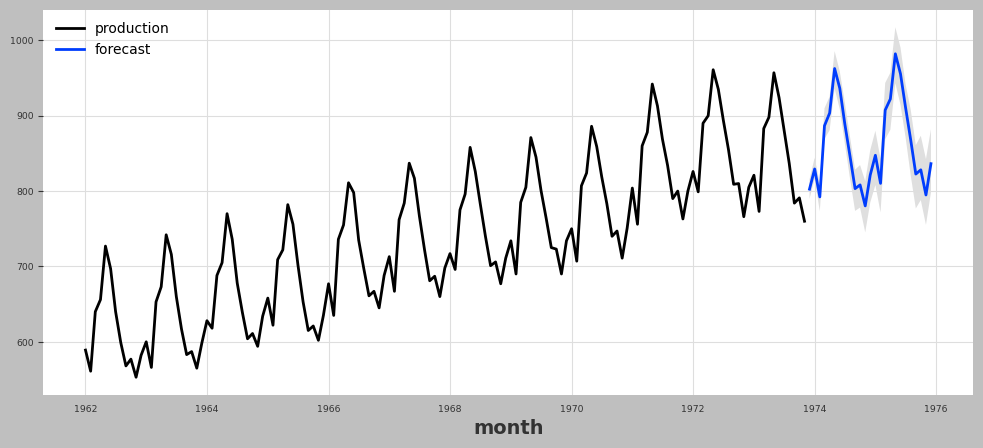

In [59]:
train.plot()
forecast.plot(label='forecast', low_quantile=0.05, high_quantile=0.95, default_formatting=False);
# plt.savefig('images/fig_10.9.png', bbox_inches='tight', dpi=300)

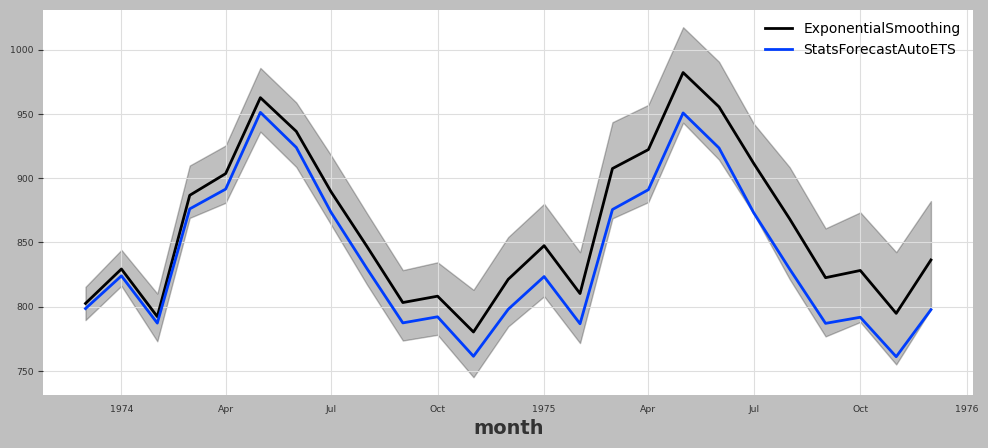

In [60]:
forecast.plot(label='ExponentialSmoothing')
etsforecast.plot(label='StatsForecastAutoETS');

In [61]:
model.model.summary()

Dep. Variable:,endog,No. Observations:,143
Model:,ExponentialSmoothing,SSE,7265.655
Optimized:,True,AIC,593.714
Trend:,Additive,BIC,641.119
Seasonal:,Additive,AICC,599.230
Seasonal Periods:,12,Date:,"Thu, 18 Apr 2024"
Box-Cox:,False,Time:,20:19:57
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6859230,alpha,True
smoothing_trend,3.8601e-10,beta,True


# Recipe 3. Forecasting Univariate Time Series Data with Non-Seasonal ARIMA

In [62]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
plt.rcParams["figure.figsize"] = [14, 4]  

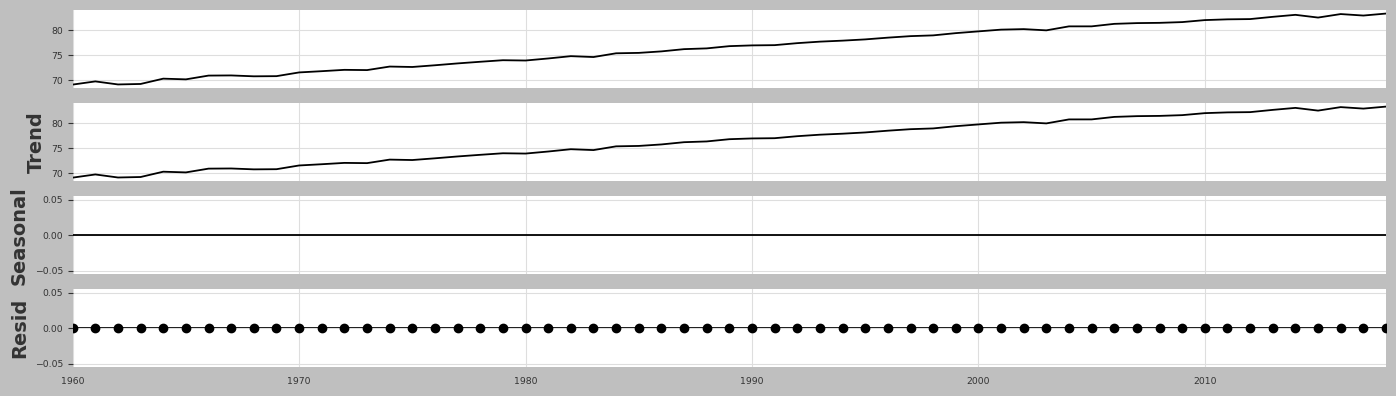

In [63]:
decomposed = seasonal_decompose(life)
decomposed.plot();
#plt.savefig('images/fig_10.10.png', bbox_inches='tight', dpi=300)

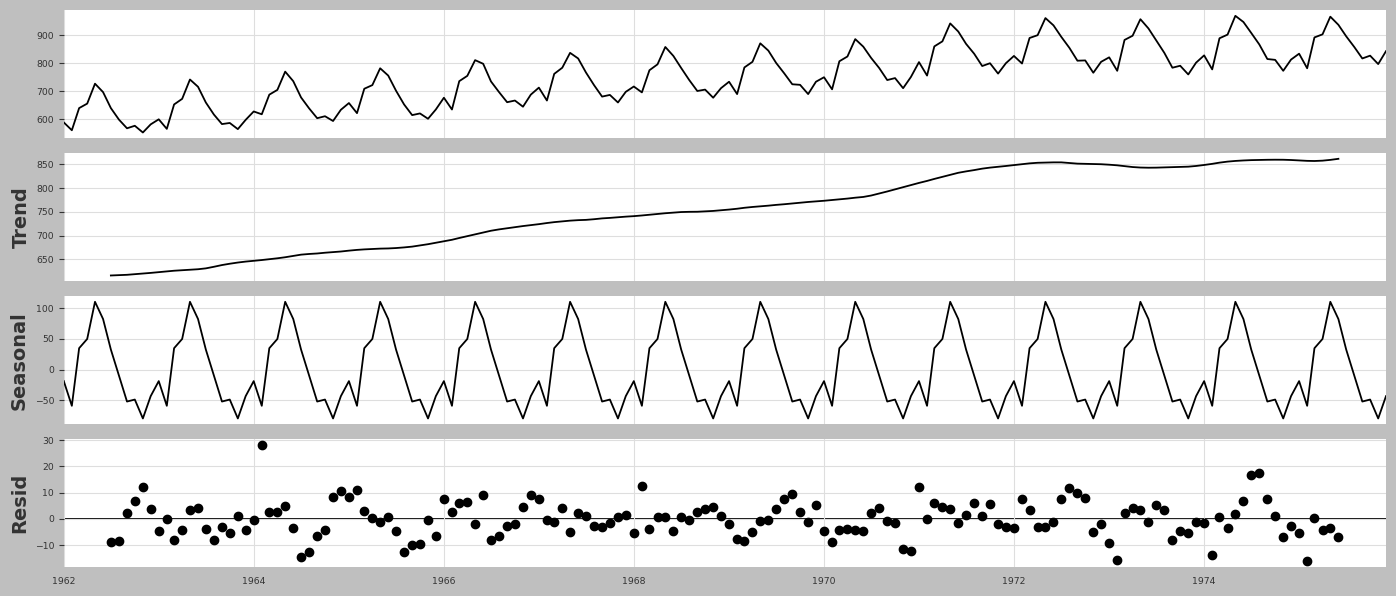

In [64]:
plt.rcParams["figure.figsize"] = [14, 6]  
decomposed = seasonal_decompose(milk, period=12)
decomposed.plot();

In [65]:
from pandas.plotting import autocorrelation_plot

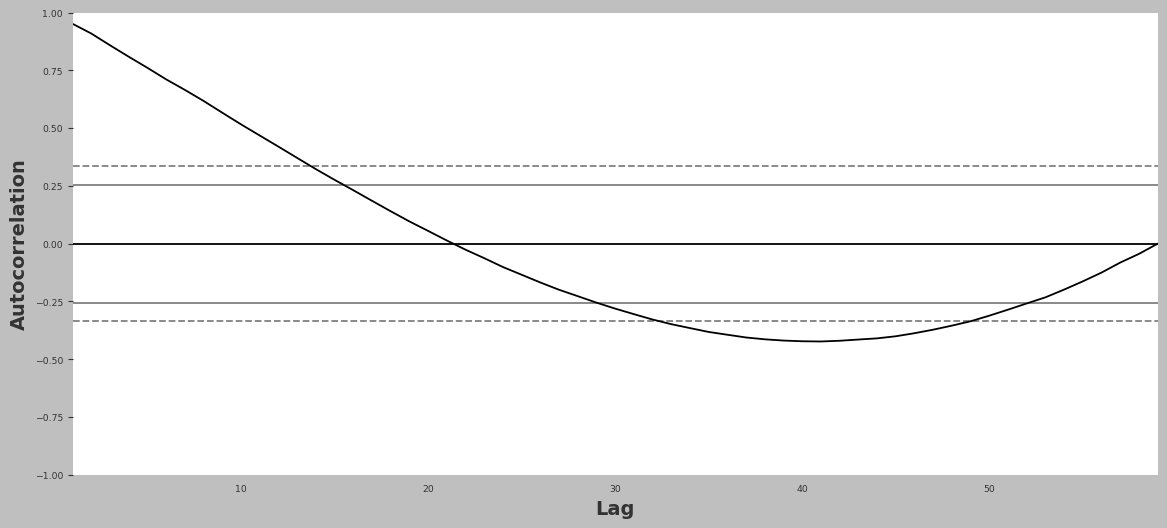

In [66]:
autocorrelation_plot(life);

In [67]:
check_stationarity(life)

'Non-Stationary	 p-value:0.6420882853800064 	 lags:2


('Non-Stationary', 0.6420882853800064)

In [68]:
life_df1 = life.diff().dropna()
check_stationarity(life_df1)

'Stationary	 p-value:1.5562189676002793e-14 	 lags:1


('Stationary', 1.5562189676002793e-14)

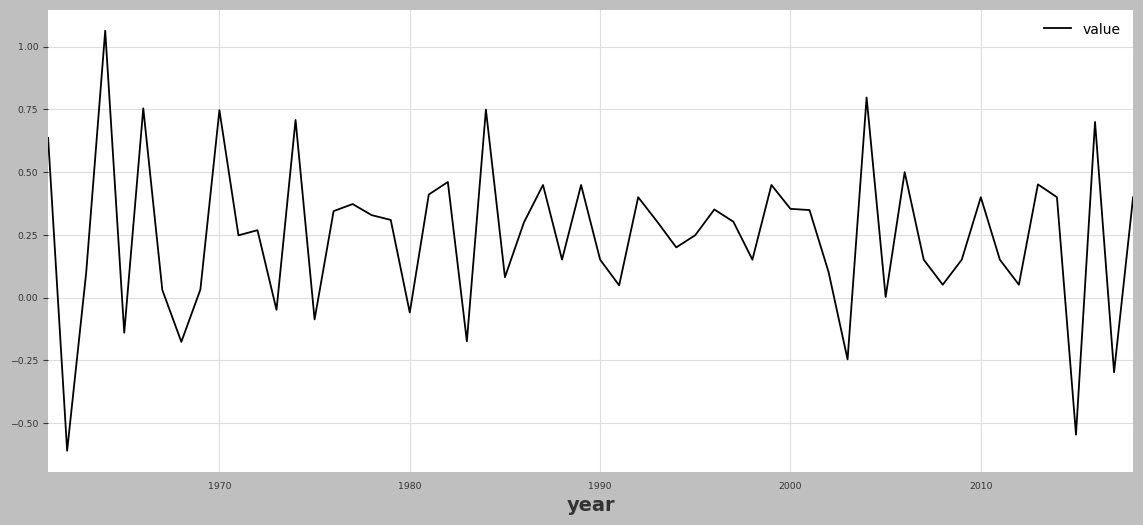

In [69]:
life_df1.plot();
#plt.savefig('images/fig_10.11.png', bbox_inches='tight', dpi=300)

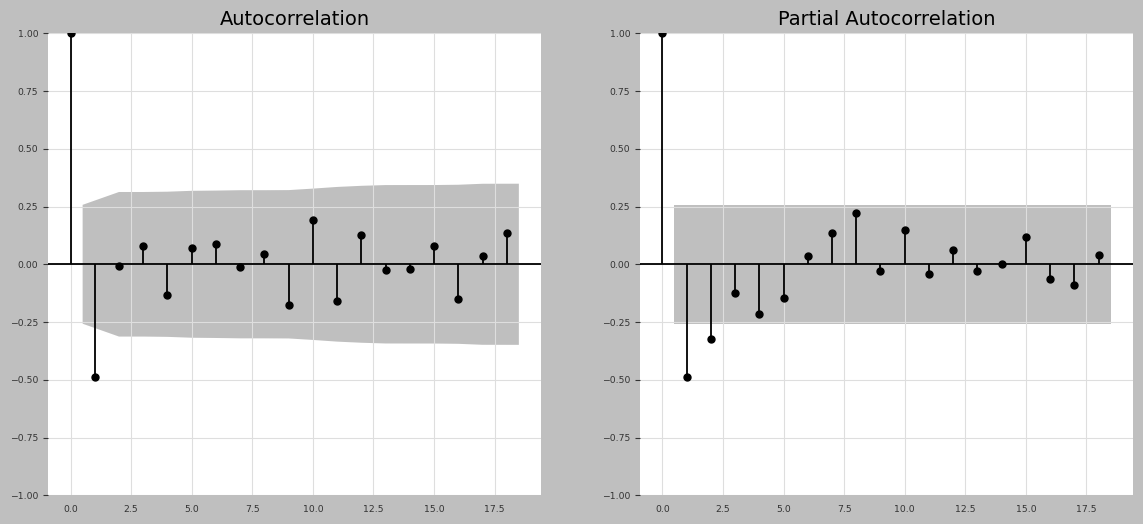

In [70]:
fig, ax = plt.subplots(1,2)
plot_acf(life_df1, ax=ax[0])
plot_pacf(life_df1, ax=ax[1]);
#plt.savefig('images/fig_10.12.png', bbox_inches='tight', dpi=300)

In [71]:
(acorr_ljungbox(life_df1, 
                lags=25,
                return_df=True) < 0.05)['lb_pvalue'].sum()
# there is autocorrelation as we would expect 

24

In [72]:
model = ARIMA(life_train, order=(0,1,1))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   50
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 -24.161
Date:                Thu, 18 Apr 2024   AIC                             52.321
Time:                        20:19:58   BIC                             56.105
Sample:                    01-01-1960   HQIC                            53.757
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0827      0.200      0.413      0.680      -0.310       0.475
sigma2         0.1569      0.032      4.918      0.000       0.094       0.219
===================================================================================
Ljung-Box (L1) (Q):                  12.54   Jarque-Bera (JB):                 0.56
Prob(Q):                              0.00   Prob(JB):                         0.76
Heteroskedasticity (H):               0.43   Skew:                             0.07
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [73]:
(acorr_ljungbox(results.resid, 
                lags=25,
                return_df=True) < 0.05)['lb_pvalue'].sum()

0

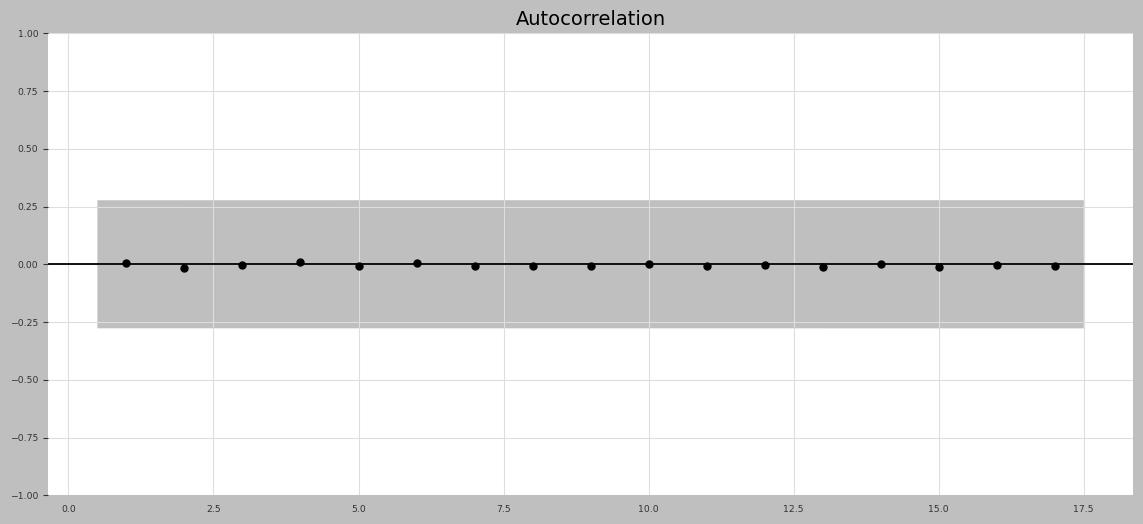

In [74]:
plot_acf(results.resid, zero=False);plt.show()

In [75]:
# from statsmodels.graphics.gofplots import qqplot

# pd.Series(results.resid).plot(kind='kde');plt.show()
# qqplot(results.resid, line='s'); plt.show()

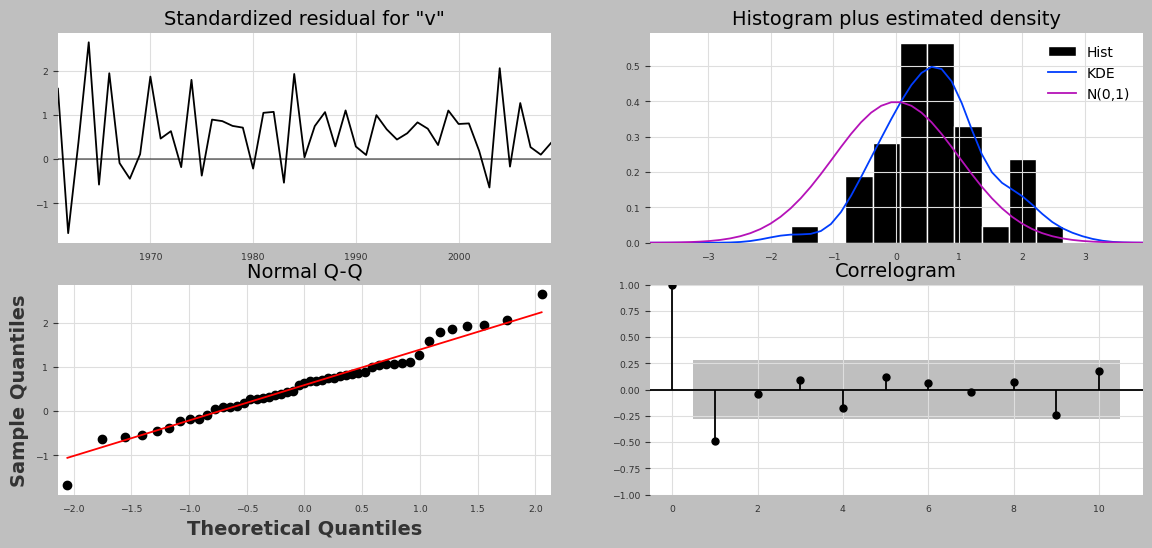

In [76]:
results.plot_diagnostics()
#plt.savefig('images/fig_10.15.png', bbox_inches='tight', dpi=300)
plt.show()

In [77]:
(acorr_ljungbox(results.resid, 
                lags=25,
                return_df=True) < 0.05)['lb_pvalue'].sum()

0

In [78]:
from scipy.stats import shapiro
shapiro(results.resid)[1] < 0.05

True

<Axes: xlabel='year'>

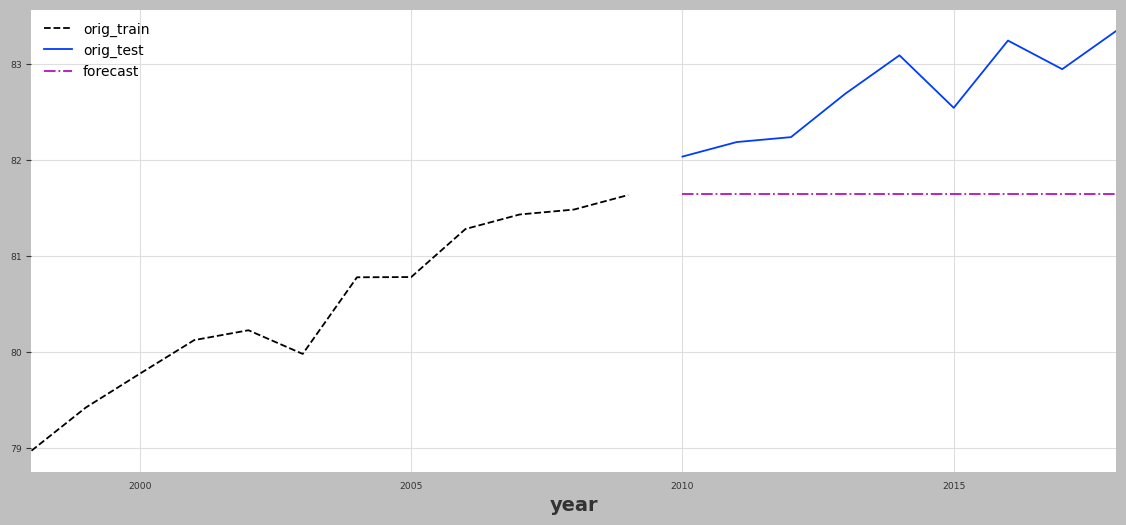

In [79]:
plot_forecast(results, '1998', life_train, life_test)

## There is more

In [80]:
pv, dv, qv = [list(range(3))]*3
vals = combinator([pv, dv, qv])
score = {}
for i, (p, d, q) in enumerate(vals):
    m = ARIMA(life_train, order=(p,d,q))
    res = m.fit()
    y = life_test.values.ravel() 
    y_hat = res.forecast(steps=len(y))
    score[i] = {'order': (p,d,q),
                'AIC':res.aic, 
                'BIC': res.bic,
                'AICc':res.aicc,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': res}

In [81]:
get_top_models_df(score, 'AIC')

,order,AIC,BIC,AICc,RMSPE,RMSE,MAPE,model
model_id,,,,,,,,
8,"(0, 2, 2)",7.698027,13.311630,8.243481,0.055954,0.463563,0.004494,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
14,"(1, 1, 2)",9.533201,17.100482,10.442291,0.054757,0.453630,0.004395,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
17,"(1, 2, 2)",9.675284,17.160088,10.605516,0.055731,0.461712,0.004469,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
23,"(2, 1, 2)",11.507920,20.967022,12.903269,0.054476,0.451301,0.004365,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
26,"(2, 2, 2)",13.832405,23.188410,15.260976,0.074418,0.616886,0.006217,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


In [82]:
best_m = get_top_models_df(score, 'AIC').iloc[0,-1]

In [83]:
get_top_models_df(score, 'MAPE', top_n=10)

,order,AIC,BIC,AICc,RMSPE,RMSE,MAPE,model
model_id,,,,,,,,
13,"(1, 1, 1)",33.428462,39.103923,33.961796,0.043376,0.359578,0.003379,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
22,"(2, 1, 1)",25.298436,32.865717,26.207527,0.046754,0.387637,0.003497,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
16,"(1, 2, 1)",23.191253,28.804856,23.736708,0.048504,0.402174,0.003586,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
7,"(0, 2, 1)",31.313324,35.055726,31.579991,0.047370,0.392761,0.003600,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
6,"(0, 2, 0)",75.831954,77.703155,75.918910,0.045215,0.375163,0.003742,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
25,"(2, 2, 1)",19.673801,27.158605,20.604034,0.054421,0.451286,0.003984,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
23,"(2, 1, 2)",11.507920,20.967022,12.903269,0.054476,0.451301,0.004365,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
14,"(1, 1, 2)",9.533201,17.100482,10.442291,0.054757,0.453630,0.004395,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
17,"(1, 2, 2)",9.675284,17.160088,10.605516,0.055731,0.461712,0.004469,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


In [84]:
best_m.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                   50
Model:                 ARIMA(0, 2, 2)   Log Likelihood                  -0.849
Date:                Thu, 18 Apr 2024   AIC                              7.698
Time:                        20:20:00   BIC                             13.312
Sample:                    01-01-1960   HQIC                             9.819
                         - 01-01-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.9456      5.889     -0.330      0.741     -13.488       9.596
ma.L2          0.9978      6.034      0.165      0.869     -10.828      12.824
sigma2         0.0500      0.303      0.165      0.869      -0.545       0.645
===================================================================================
Ljung-Box (L1) (Q):                   0.31   Jarque-Bera (JB):                 1.82
Prob(Q):                              0.58   Prob(JB):                         0.40
Heteroskedasticity (H):               0.38   Skew:                             0.17
Prob(H) (two-sided):                  0.06   Kurtosis:                         3.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

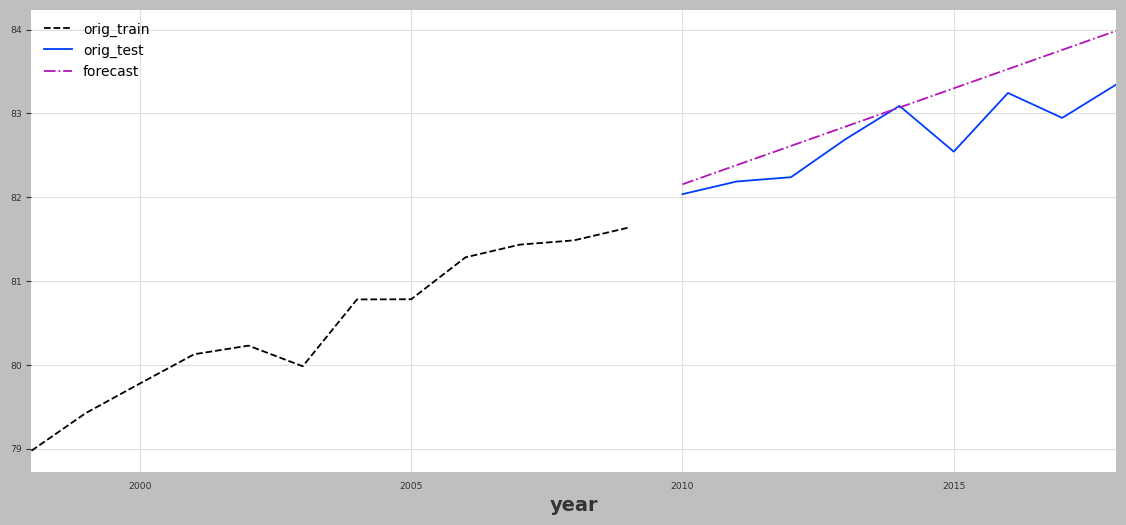

In [85]:
plot_forecast(best_m, '1998', life_train, life_test);

In [86]:
pv, dv, qv = [list(range(3))]*3
vals = combinator([pv, dv, qv])
score = {}
for i, (p, d, q) in enumerate(vals):
    m = ARIMA(milk_train, order=(p,d,q))
    res = m.fit()
    y = milk_test.values.ravel() 
    y_hat = res.forecast(steps=len(y))
    score[i] = {'order': (p,d,q),
                'AIC':res.aic, 
                'BIC': res.bic,
                'AICc':res.aicc,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': res}

In [87]:
get_top_models_df(score, 'AIC')

,order,AIC,BIC,AICc,RMSPE,RMSE,MAPE,model
model_id,,,,,,,,
26,"(2, 2, 2)",1445.411301,1460.155100,1445.855745,1.130906,103.392533,0.097151,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
23,"(2, 1, 2)",1458.932327,1473.711462,1459.373503,1.052131,96.733984,0.086554,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
5,"(0, 1, 2)",1466.122925,1474.990406,1466.296838,1.271762,115.822624,0.112387,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
14,"(1, 1, 2)",1466.878216,1478.701525,1467.170187,1.234587,112.601237,0.108002,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...
11,"(1, 0, 2)",1467.165995,1481.980218,1467.603951,1.457496,131.857306,0.133059,<statsmodels.tsa.arima.model.ARIMAResultsWrapp...


In [88]:
model = get_top_models_df(score, 'AIC').iloc[0,-1]

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             production   No. Observations:                  143
Model:                 ARIMA(2, 2, 2)   Log Likelihood                -717.706
Date:                Thu, 18 Apr 2024   AIC                           1445.411
Time:                        20:20:01   BIC                           1460.155
Sample:                    01-01-1962   HQIC                          1451.403
                         - 11-01-1973                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7321      0.004   -400.810      0.000      -1.741      -1.724
ar.L2         -0.9995      0.002   -448.174      0.000      -1.004      -0.995
ma.L1          1.7117      1.628      1.051      0.293      -1.480       4.903
ma.L2          0.9992      1.895      0.527      0.598      -2.715       4.713
sigma2      1446.0617   2670.048      0.542      0.588   -3787.137    6679.260
===================================================================================
Ljung-Box (L1) (Q):                   3.55   Jarque-Bera (JB):                10.57
Prob(Q):                              0.06   Prob(JB):                         0.01
Heteroskedasticity (H):               1.27   Skew:                             0.67
Prob(H) (two-sided):                  0.42   Kurtosis:                         2.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

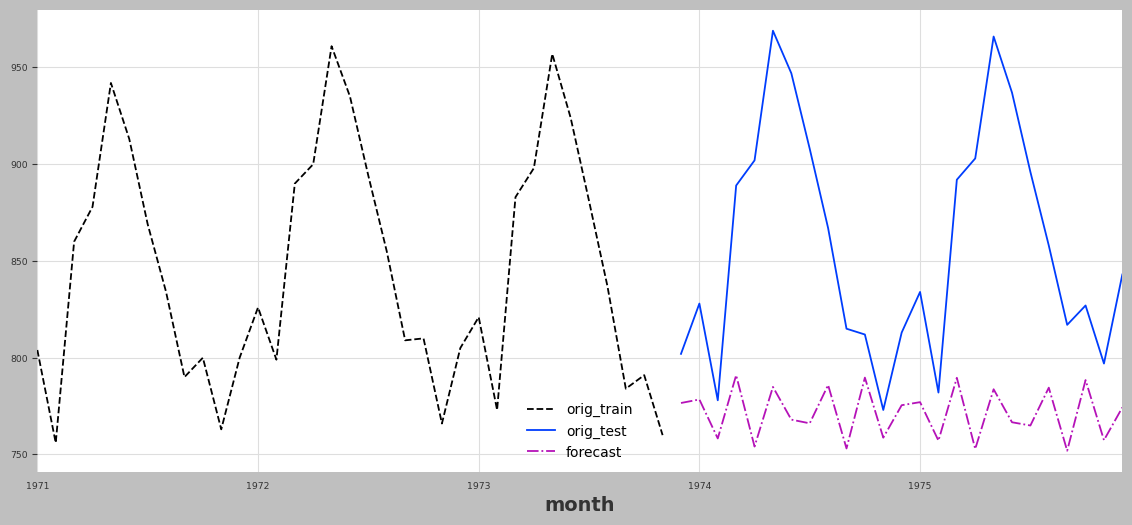

In [89]:
plot_forecast(model, '1971', milk_train, milk_test);

# Recipe 4. Forecasting Univariate Time Series Data with Seasonal ARIMA

In [90]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
plt.rcParams["figure.figsize"] = [14, 4]  

<Axes: xlabel='month'>

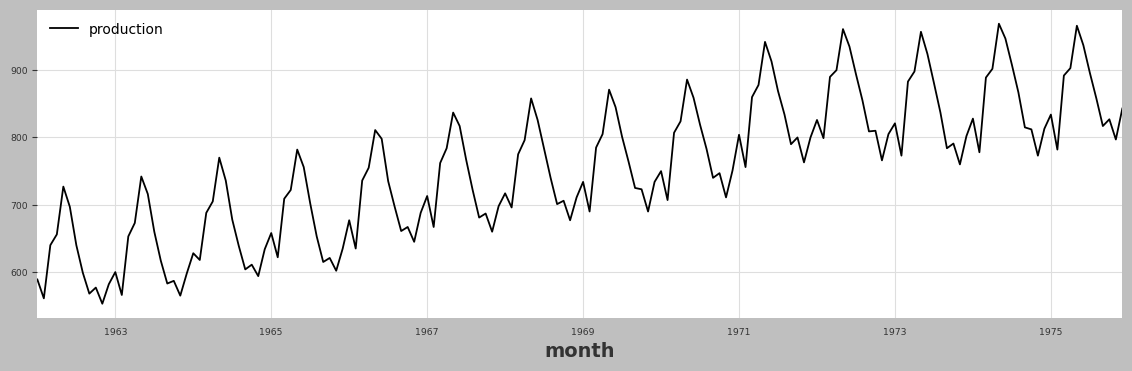

In [91]:
milk.plot()

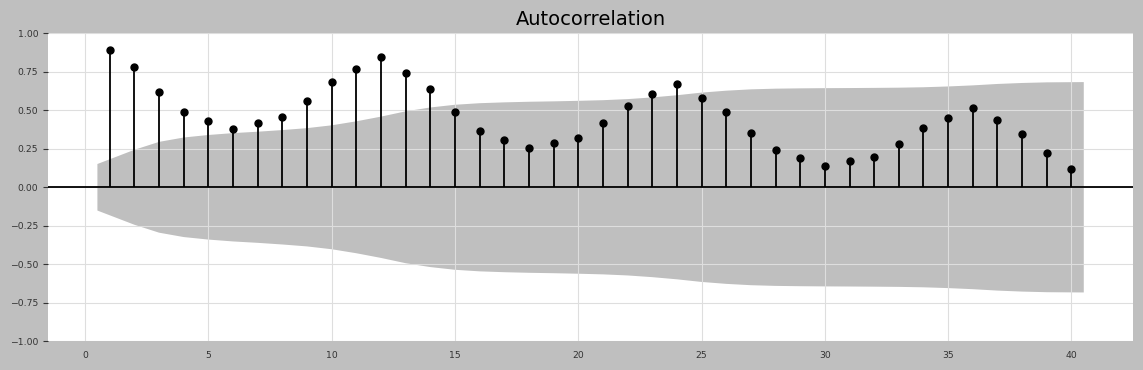

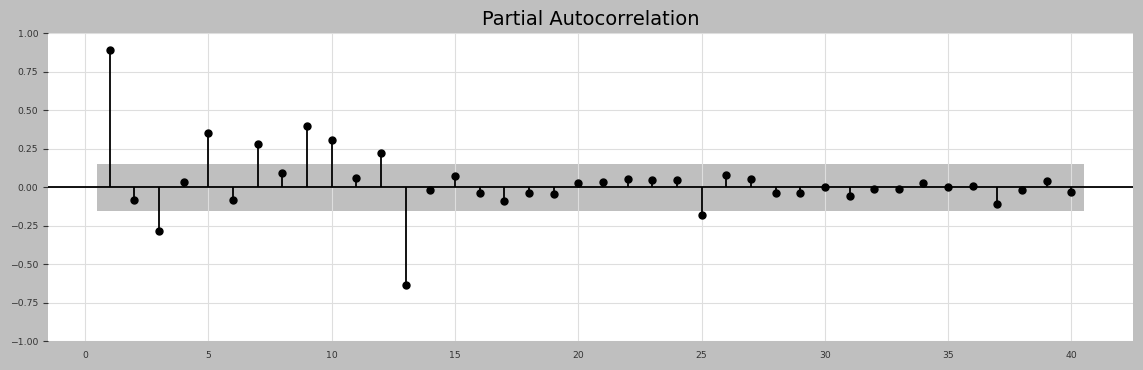

In [92]:
plot_acf(milk, lags=40, zero=False)
plot_pacf(milk, lags=40, zero=False);plt.show()

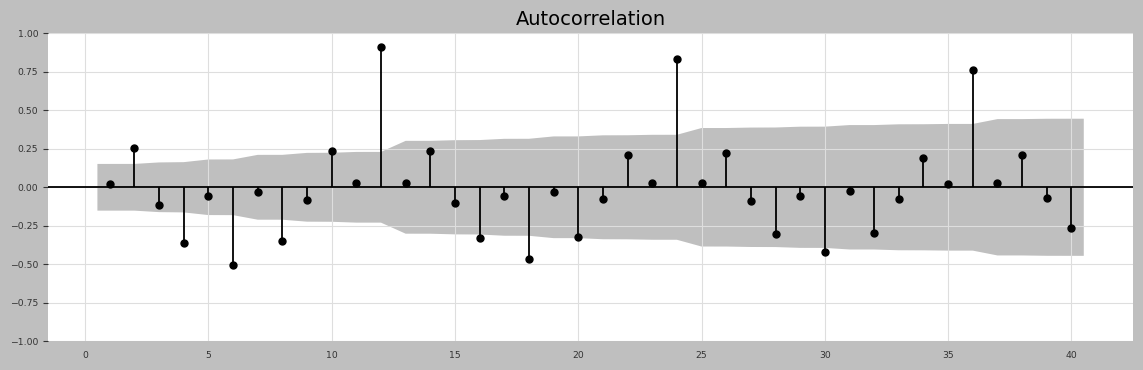

In [93]:
plot_acf(milk.diff(1).dropna(), lags=40, zero=False); 

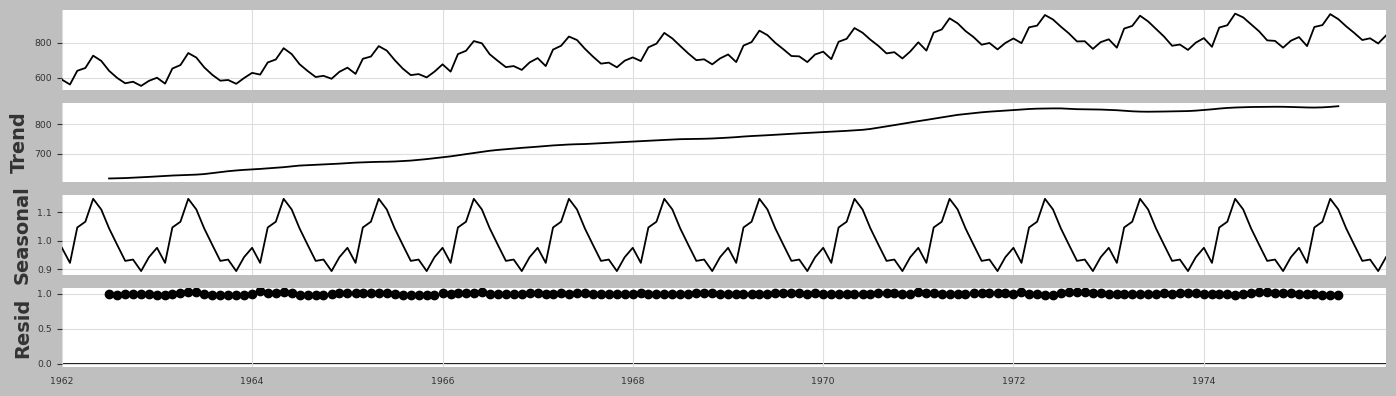

In [94]:
decomposed = seasonal_decompose(milk, period=12, model='multiplicative')
decomposed.plot(); 

In [95]:
milk_s = decomposed.seasonal

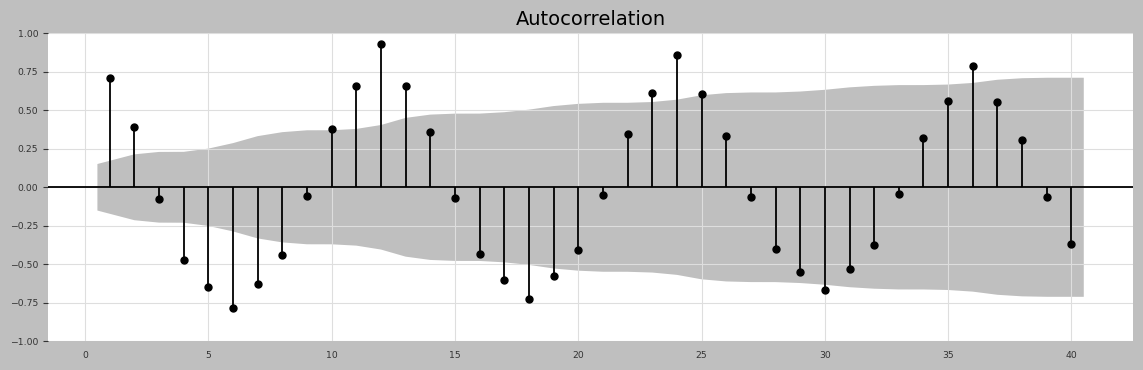

In [96]:
plot_acf(milk_s, zero=False, lags=40);plt.show()

In [97]:
milk_dif_12 = milk.diff(12).dropna()
milk_dif_12_1 = milk.diff(12).diff(1).dropna()

'Non-Stationary	 p-value:0.6274267086030357 	 lags:13
'Non-Stationary	 p-value:0.1607988052771132 	 lags:12
'Stationary	 p-value:1.8654234318790463e-05 	 lags:11


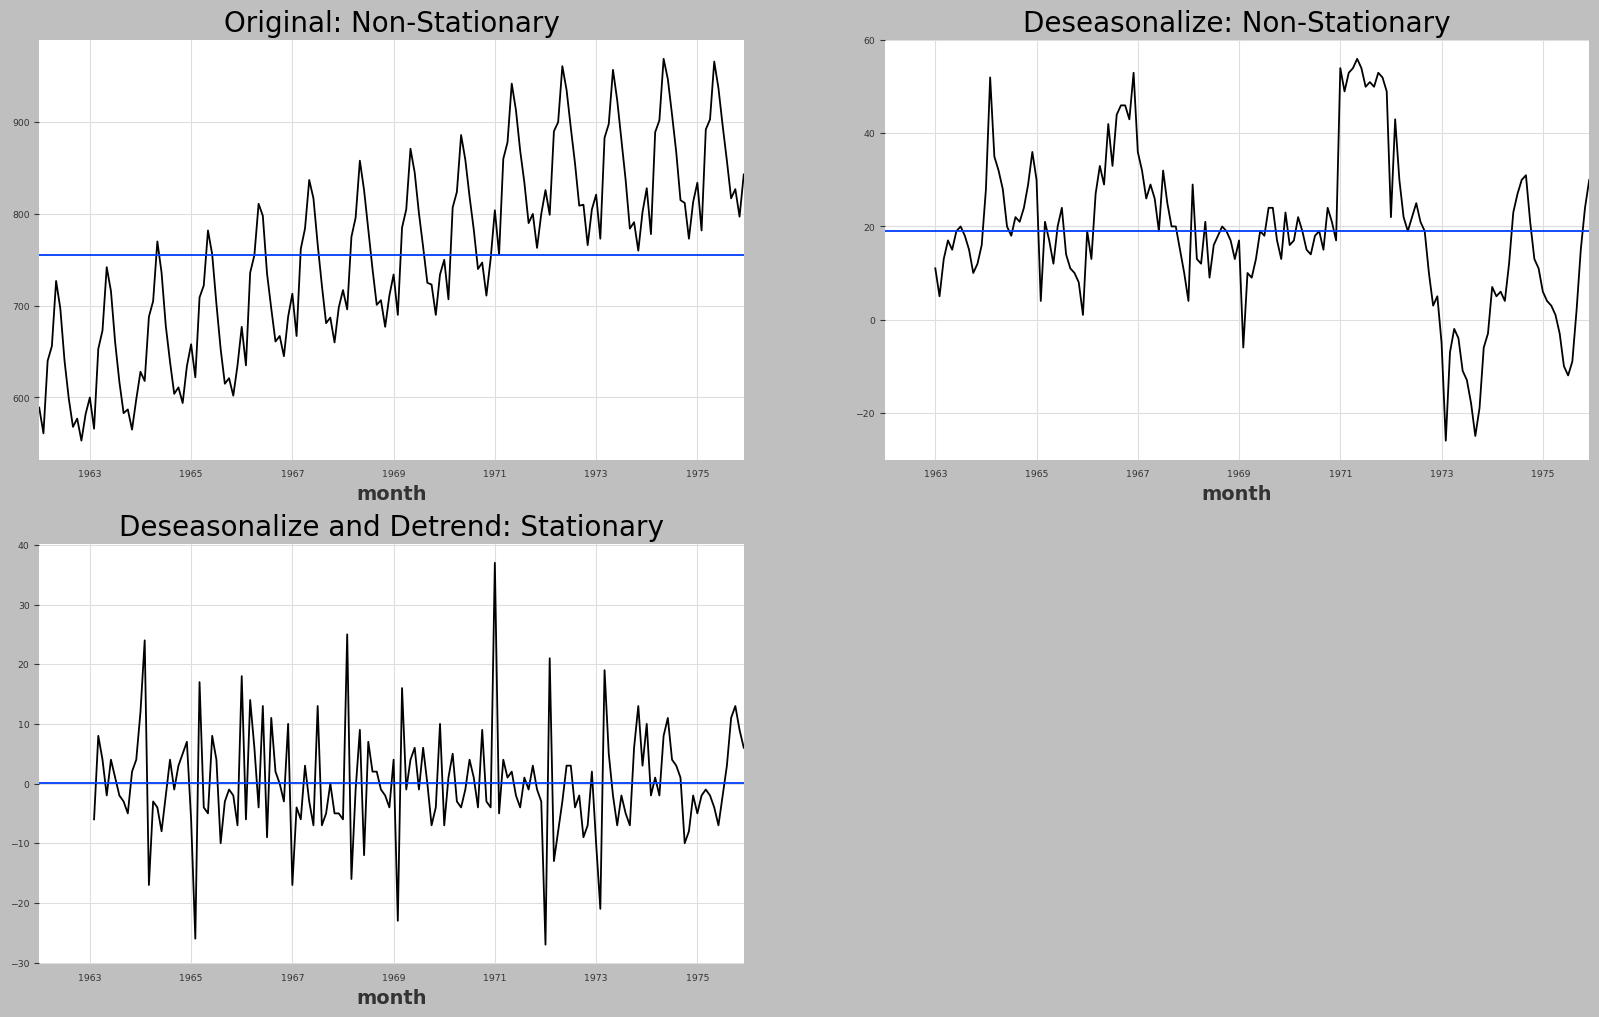

In [98]:
sets = [milk, milk_dif_12, milk_dif_12_1]
desc = ['Original', 'Deseasonalize', 'Deseasonalize and Detrend']
fig, ax = plt.subplots(2,2, figsize=(20,12))
index, l = milk.index, milk.shape[0]
for i, (d_set, d_desc) in enumerate(zip(sets, desc)):
    v, r = i // 2, i % 2
    outcome, pval = check_stationarity(d_set)
    d_set.plot(ax= ax[v,r], title=f'{d_desc}: {outcome}', legend=False)
    pd.Series(d_set.mean().values.tolist()*l, index=index).plot(ax=ax[v,r])
    ax[v,r].title.set_size(20)
ax[1,1].set_visible(False)
# plt.savefig('images/fig_10.21.png', bbox_inches='tight', dpi=300)
plt.show()

### How to Determine AR and MA terms

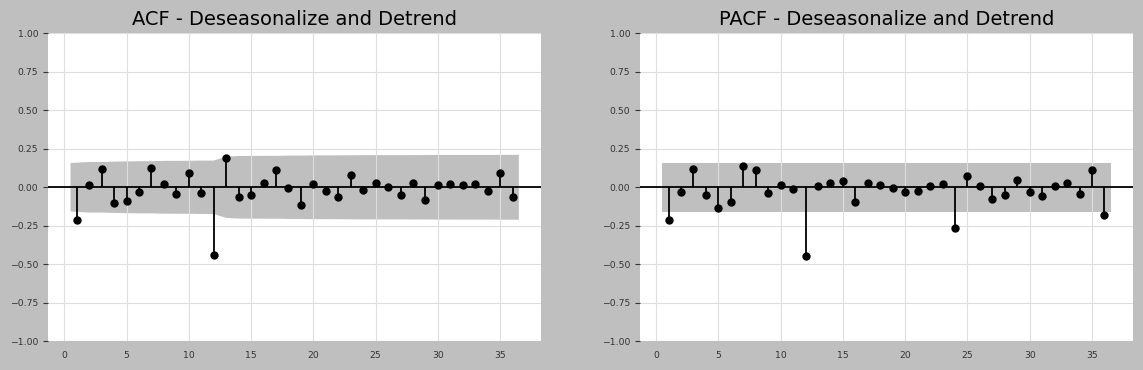

In [99]:
fig, ax = plt.subplots(1,2)
plot_acf(milk_dif_12_1, zero=False, lags=36, ax=ax[0], title=f'ACF - {d_desc}')
plot_pacf(milk_dif_12_1, zero=False, lags=36, ax=ax[1], title=f'PACF - {d_desc}')
plt.show()

[1, 12, 24, 36, 48]


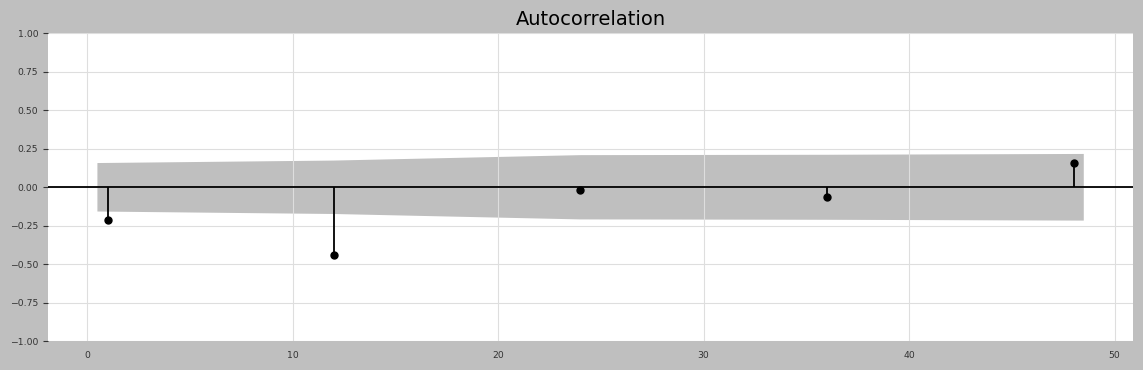

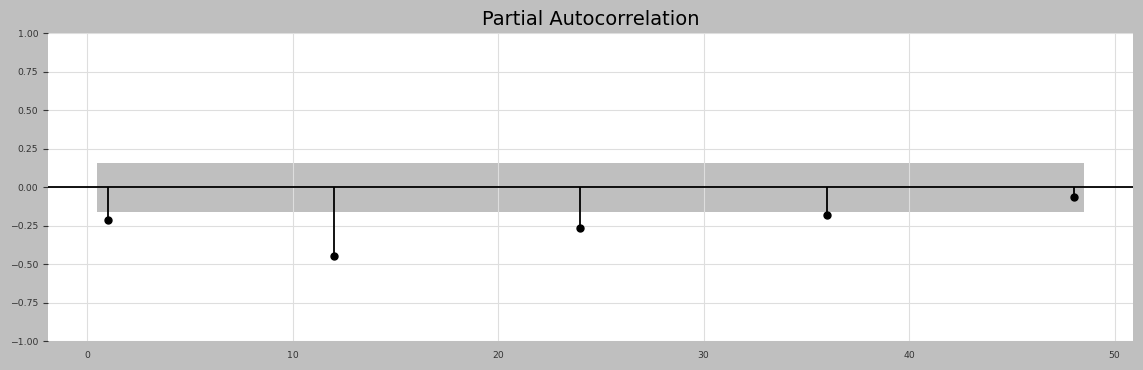

In [100]:
#lags = [1, 12, 24, 36, 48]
lags = [i for i in range(12, 60, 12)]
lags.insert(0, 1)
print(lags)
plot_acf(milk.diff(12).diff(1).dropna(),zero=False, lags=lags)
plot_pacf(milk.diff(12).diff(1).dropna(),zero=False, lags=lags);

### Fitting a SARIMA Model

In [101]:
sarima_model = SARIMAX(milk_train, 
                       order=(0,1,1),
                       seasonal_order=(0,1,1,12))
model = sarima_model.fit(disp=0)

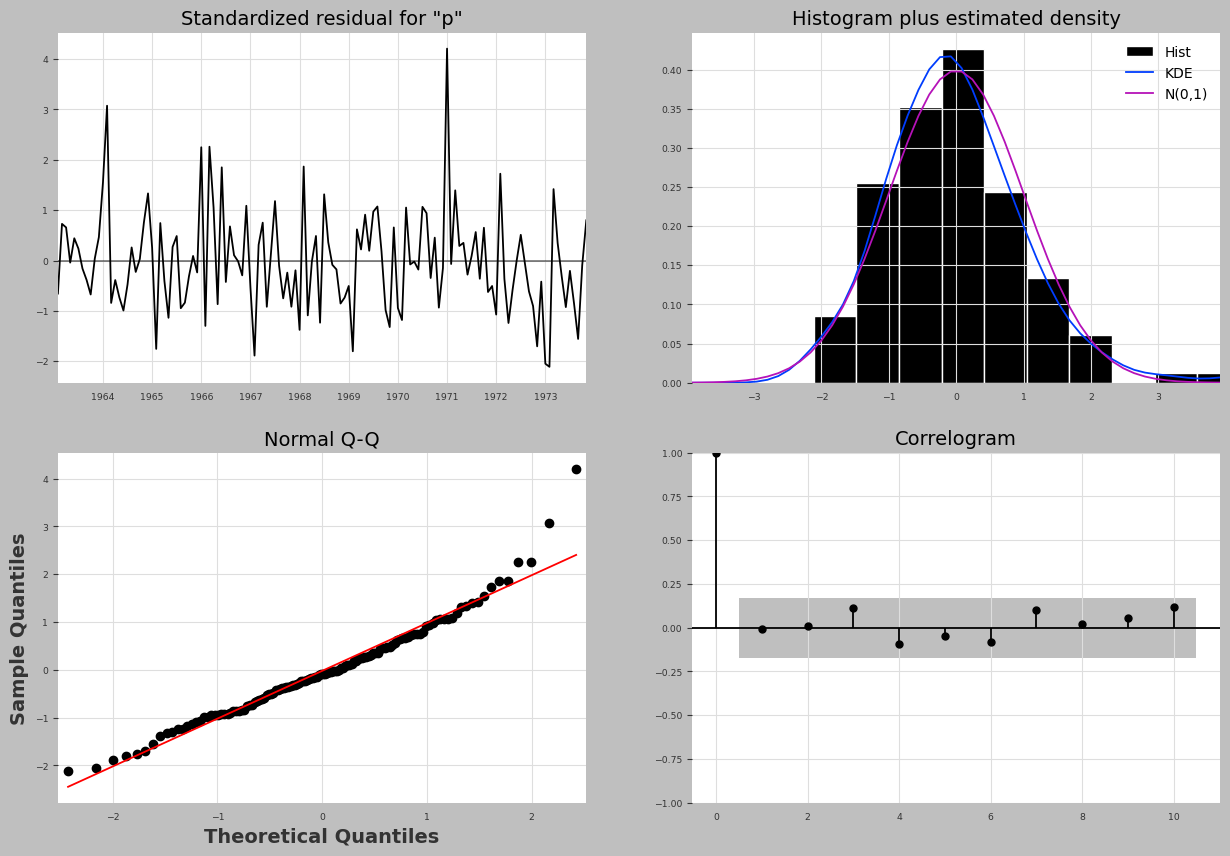

In [102]:
model.plot_diagnostics(figsize=(15,10));
# plt.savefig('images/fig_10.23.png', bbox_inches='tight', dpi=300)

In [103]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         production   No. Observations:                  143
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -448.668
Date:                            Thu, 18 Apr 2024   AIC                            903.335
Time:                                    20:20:04   BIC                            911.938
Sample:                                01-01-1962   HQIC                           906.831
                                     - 11-01-1973                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2811      0.084     -3.331      0.001      -0.446      -0.116
ma.S.L12      -0.6334      0.083     -7.653      0.000      -0.796      -0.471
sigma2        55.5239      5.753      9.650      0.000      44.247      66.800
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                35.77
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.82
Prob(H) (two-sided):                  0.65   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

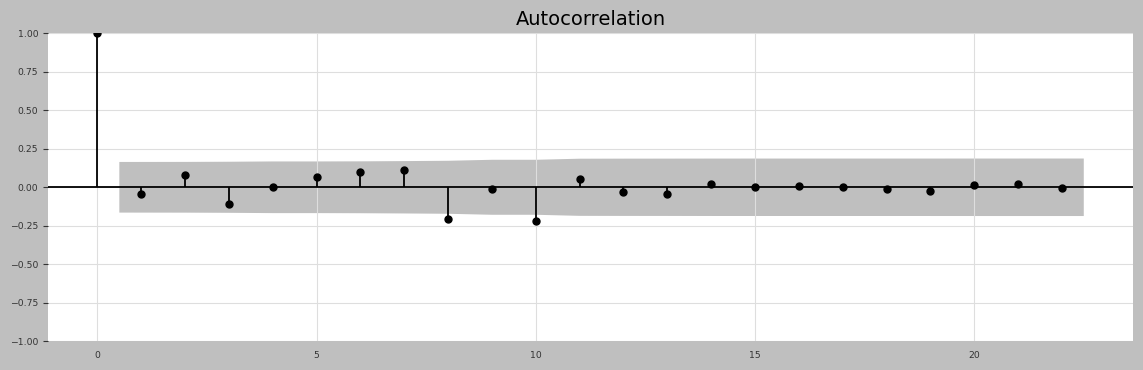

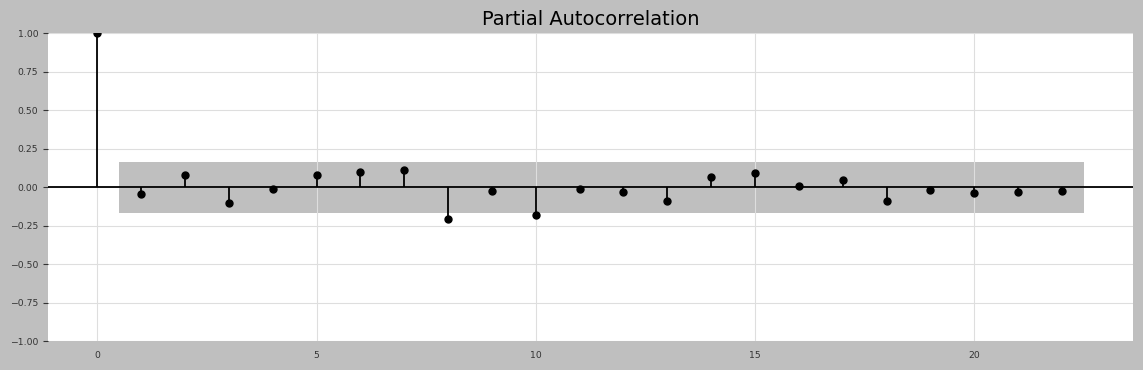

In [104]:
plot_acf(model.resid[1:]);
plot_pacf(model.resid[1:]); 

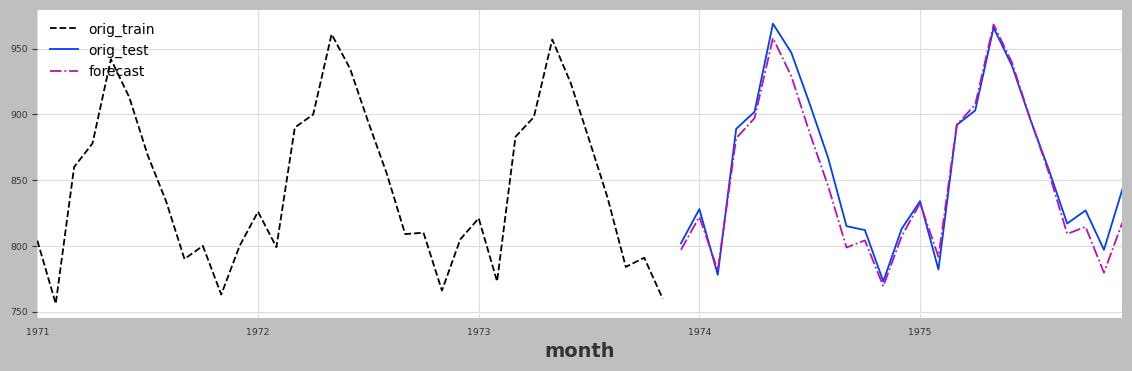

In [105]:
plot_forecast(model, '1971', milk_train, milk_test);
# plt.savefig('images/fig_10.24.png', bbox_inches='tight', dpi=300)

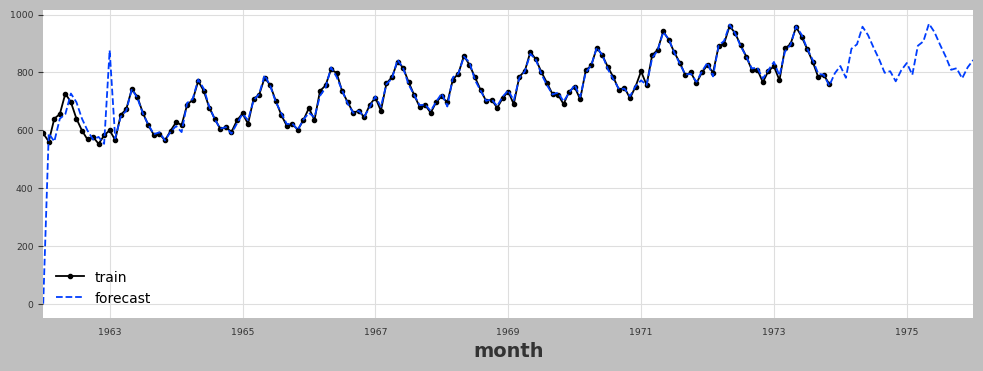

In [106]:
n = milk.shape[0]
milk_train.plot(style='.-', figsize=(12,4))
model.predict(end=n).plot(style='--')
plt.legend(['train', 'forecast'])

## There is more

In [107]:
%%time
P_ns, D_ns, Q_ns = [list(range(3))]*3
P_s, D_s, Q_s = [list(range(2))]*3

vals = combinator([P_ns, D_ns, Q_ns, P_s, D_s, Q_s])
score = {}
for i, (p, d, q, P, D, Q) in enumerate(vals):
    if i%15 == 0:
        print(f'Running model #{i} using SARIMA({p},{d},{q})({P},{D},{Q},12)')
    m = SARIMAX(milk_train, 
                order=(p,d,q),
                seasonal_order=(P, D, Q, 12),
                enforce_stationarity=False)
    res = m.fit(disp=0)
    y = milk_test.values.ravel() 
    y_hat = res.forecast(steps=len(y))
    score[i] = {'non-seasonal order': (p,d,q),
                'seasonal order': (P, D, Q),
                'AIC':res.aic, 
                'AICc': res.aicc,
                'BIC': res.bic,
                'RMSPE': rmspe(y, y_hat),
                'RMSE' : rmse(y, y_hat),
                'MAPE' : mape(y, y_hat),
                'model': res}

Running model #0 using SARIMA(0,0,0)(0,0,0,12)
Running model #15 using SARIMA(0,0,1)(1,1,1,12)
Running model #30 using SARIMA(0,1,0)(1,1,0,12)
Running model #45 using SARIMA(0,1,2)(1,0,1,12)
Running model #60 using SARIMA(0,2,1)(1,0,0,12)
Running model #75 using SARIMA(1,0,0)(0,1,1,12)
Running model #90 using SARIMA(1,0,2)(0,1,0,12)
Running model #105 using SARIMA(1,1,1)(0,0,1,12)
Running model #120 using SARIMA(1,2,0)(0,0,0,12)
Running model #135 using SARIMA(1,2,1)(1,1,1,12)
Running model #150 using SARIMA(2,0,0)(1,1,0,12)
Running model #165 using SARIMA(2,0,2)(1,0,1,12)
Running model #180 using SARIMA(2,1,1)(1,0,0,12)
Running model #195 using SARIMA(2,2,0)(0,1,1,12)
Running model #210 using SARIMA(2,2,2)(0,1,0,12)
CPU times: user 23.1 s, sys: 182 ms, total: 23.3 s
Wall time: 23.4 s


In [108]:
3*3*3*2*2*2

216

In [109]:
get_top_models_df(score, 'AIC')

,non-seasonal order,seasonal order,AIC,AICc,BIC,RMSPE,RMSE,MAPE,model
model_id,,,,,,,,,
211,"(2, 2, 2)","(0, 1, 1)",795.421765,796.206812,811.838956,0.178190,15.135862,0.014454,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
67,"(0, 2, 2)","(0, 1, 1)",795.515920,795.882892,806.460713,0.328238,27.797088,0.028315,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
43,"(0, 1, 2)","(0, 1, 1)",796.763902,797.127539,807.743631,0.134089,11.487076,0.010387,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
187,"(2, 1, 2)","(0, 1, 1)",796.876071,797.653849,813.345664,0.128260,10.998613,0.010075,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
139,"(1, 2, 2)","(0, 1, 1)",797.117088,797.672643,810.798080,0.289726,24.535304,0.024769,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


In [110]:
get_top_models_df(score, 'BIC')

,non-seasonal order,seasonal order,AIC,AICc,BIC,RMSPE,RMSE,MAPE,model
model_id,,,,,,,,,
67,"(0, 2, 2)","(0, 1, 1)",795.515920,795.882892,806.460713,0.328238,27.797088,0.028315,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
43,"(0, 1, 2)","(0, 1, 1)",796.763902,797.127539,807.743631,0.134089,11.487076,0.010387,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
35,"(0, 1, 1)","(0, 1, 1)",802.462674,802.676959,810.723444,0.134090,11.489677,0.010370,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
139,"(1, 2, 2)","(0, 1, 1)",797.117088,797.672643,810.798080,0.289726,24.535304,0.024769,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...
211,"(2, 2, 2)","(0, 1, 1)",795.421765,796.206812,811.838956,0.178190,15.135862,0.014454,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...


In [112]:
best_model = get_top_models_df(score, 'BIC').iloc[0,-1]
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           production   No. Observations:                  143
Model:             SARIMAX(0, 2, 2)x(0, 1, [1], 12)   Log Likelihood                -393.758
Date:                              Thu, 18 Apr 2024   AIC                            795.516
Time:                                      20:20:45   BIC                            806.461
Sample:                                  01-01-1962   HQIC                           799.958
                                       - 11-01-1973                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.2806      0.096    -13.353      0.000      -1.469      -1.093
ma.L2          0.3054      0.107      2.860      0.004       0.096       0.515
ma.S.L12      -0.6217      0.082     -7.556      0.000      -0.783      -0.460
sigma2        56.9487      6.214      9.165      0.000      44.769      69.128
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                28.17
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               1.30   Skew:                             0.76
Prob(H) (two-sided):                  0.42   Kurtosis:                         4.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

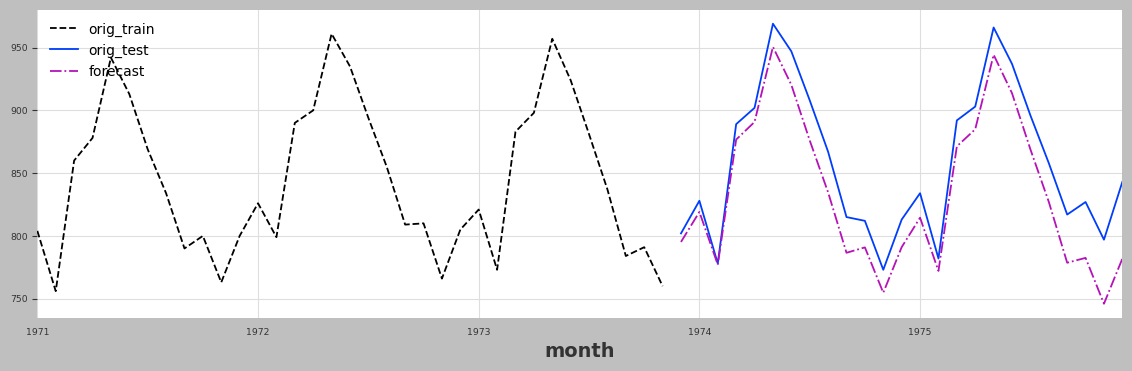

In [113]:
plot_forecast(best_model, '1971', milk_train, milk_test);
# plt.savefig('images/fig_10.25.png', bbox_inches='tight', dpi=300)

# Recipe 5: Forecasting Time Series Data using Auto_ARIMA

You will need to install pmdarima before you can proceed with this recipe. 

* To install it using `pip`, use the following command:

```
pip install pmdarima
```

* To install it using `conda`, use the following command:
```
conda install -c conda-forge pmdarima

In [1]:
import pmdarima as pm

In [2]:
pm.__version__

'2.0.4'

In [10]:
milk_train.shape

(143, 1)

In [11]:
milk_test.shape

(25, 1)

In [12]:
milk_train.head()

,production
month,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


In [13]:
auto_model = pm.auto_arima(milk_train, 
                           seasonal=True, 
                           m=12, 
                           test='adf',
                           stepwise=True)

In [14]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  143
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -448.668
Date:                            Sat, 12 Oct 2024   AIC                            903.335
Time:                                    12:48:40   BIC                            911.938
Sample:                                01-01-1962   HQIC                           906.831
                                     - 11-01-1973                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2811      0.084     -3.331      0.001      -0.446      -0.116
ma.S.L12      -0.6334      0.083     -7.653      0.000      -0.796      -0.471
sigma2        55.5239      5.753      9.650      0.000      44.247      66.800
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                35.77
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.82
Prob(H) (two-sided):                  0.65   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
auto_model = pm.auto_arima(milk_train, 
                           seasonal=True, 
                           m=12, 
                           test='adf', 
                           stepwise=True,
                           trace=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=908.834, Time=1.19 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=951.320, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=917.481, Time=0.03 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=903.335, Time=0.08 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=940.547, Time=0.01 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=905.280, Time=0.15 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=905.265, Time=1.08 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=917.295, Time=0.19 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.31 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=911.816, Time=0.06 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=905.240, Time=0.11 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=905.159, Time=0.19 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=903.959, Time=0.11 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=907.070, Time=0.35 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   

In [16]:
auto_model = pm.auto_arima(milk_train, 
                           seasonal=True, 
                           m=12, 
                           test='adf', 
                           information_criterion='bic',
                           stepwise=True,
                           trace=True)

Performing stepwise search to minimize bic
 ARIMA(2,1,2)(1,1,1)[12]             : BIC=928.907, Time=0.82 sec
 ARIMA(0,1,0)(0,1,0)[12]             : BIC=954.187, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : BIC=926.083, Time=0.07 sec
 ARIMA(0,1,1)(0,1,1)[12]             : BIC=911.938, Time=0.53 sec
 ARIMA(0,1,1)(0,1,0)[12]             : BIC=946.282, Time=0.03 sec
 ARIMA(0,1,1)(1,1,1)[12]             : BIC=916.750, Time=0.13 sec
 ARIMA(0,1,1)(0,1,2)[12]             : BIC=916.735, Time=0.63 sec
 ARIMA(0,1,1)(1,1,0)[12]             : BIC=925.897, Time=0.10 sec
 ARIMA(0,1,1)(1,1,2)[12]             : BIC=inf, Time=1.97 sec
 ARIMA(0,1,0)(0,1,1)[12]             : BIC=917.551, Time=0.07 sec
 ARIMA(1,1,1)(0,1,1)[12]             : BIC=916.710, Time=0.36 sec
 ARIMA(0,1,2)(0,1,1)[12]             : BIC=916.630, Time=0.34 sec
 ARIMA(1,1,0)(0,1,1)[12]             : BIC=912.562, Time=0.39 sec
 ARIMA(1,1,2)(0,1,1)[12]             : BIC=921.407, Time=0.37 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   

In [17]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  143
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -448.668
Date:                            Sat, 12 Oct 2024   AIC                            903.335
Time:                                    12:49:26   BIC                            911.938
Sample:                                01-01-1962   HQIC                           906.831
                                     - 11-01-1973                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2811      0.084     -3.331      0.001      -0.446      -0.116
ma.S.L12      -0.6334      0.083     -7.653      0.000      -0.796      -0.471
sigma2        55.5239      5.753      9.650      0.000      44.247      66.800
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                35.77
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               1.15   Skew:                             0.82
Prob(H) (two-sided):                  0.65   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

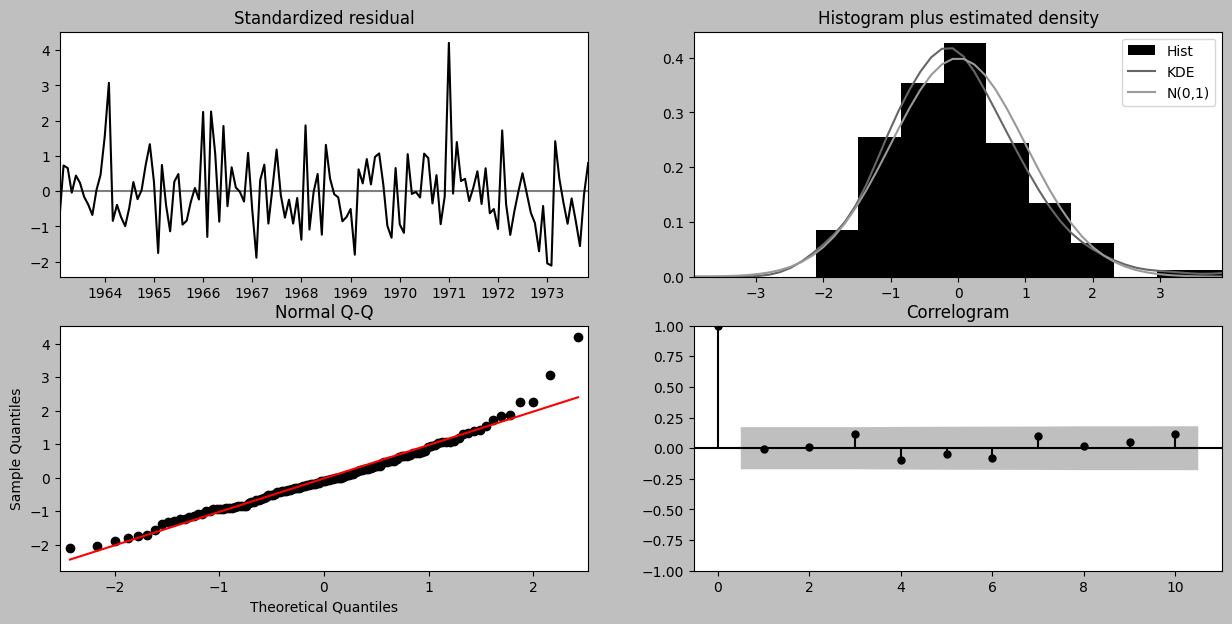

In [18]:
auto_model.plot_diagnostics(figsize=(15,7));

In [19]:
auto_model.scoring

'mse'

In [20]:
auto_model

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True, with_intercept=False)

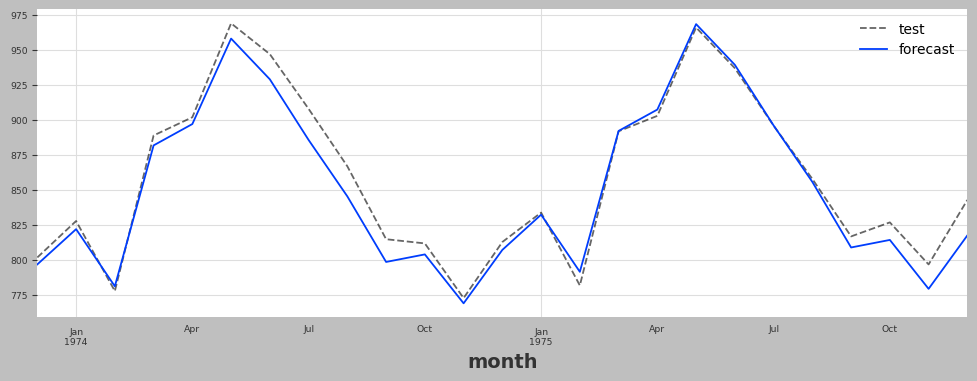

In [139]:
n = milk_test.shape[0]
index = milk_test.index
ax = milk_test.plot(style='--', alpha=0.6, figsize=(12,4))
pd.Series(auto_model.predict(n_periods=n), 
          index=index).plot(style='-', ax=ax)
plt.legend(['test', 'forecast']); plt.show()

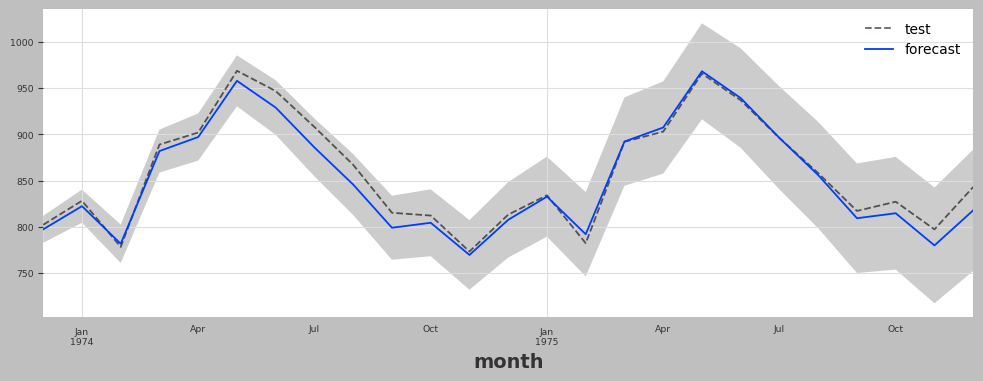

In [145]:
n = milk_test.shape[0]
forecast, conf_interval = auto_model.predict(n_periods=n, 
                                             return_conf_int=True,
                                            alpha=0.05)
lower_ci, upper_ci  = zip(*conf_interval)

index = milk_test.index
ax = milk_test.plot(style='--', alpha=0.6, figsize=(12,4))
pd.Series(forecast, index=index).plot(style='-', ax=ax)
plt.fill_between(index, lower_ci, upper_ci, alpha=0.2)
plt.legend(['test', 'forecast']);

## There is more

In [147]:
from pmdarima.arima.utils import ndiffs, nsdiffs

# ADF test:
n_adf = ndiffs(milk, test='adf') 
# KPSS test (auto_arima default):
n_kpss = ndiffs(milk, test='kpss') 
# PP test:
n_pp = ndiffs(milk, test='pp')  

In [148]:
print(f'''
differencing (d) term using:
    ADF: {n_adf}
    KPSS: {n_kpss}
    PP: {n_pp}
''')


differencing (d) term using:
    ADF: 0
    KPSS: 1
    PP: 0



In [149]:
# OCSB test
max_D = nsdiffs(milk, test='ocsb', m=12, max_D=12) 

In [150]:
print(f'''
Seasonal differencing (D) term: {max_D}
''')


Seasonal differencing (D) term: 1



In [151]:
model = pm.auto_arima(milk_train, 
                      seasonal=True,
                      with_intercept=True,
                      d=1,
                      max_d=2,
                      start_p=0, max_p=2,
                      start_q=0, max_q=2,
                      m=12,
                      D=1,
                      max_D=2,
                      start_P=0, max_P=2,
                      start_Q=0, max_Q=2,
                      information_criterion='aic',
                      stepwise=False,
                      out_of_sample_siz=25,
                      test = 'kpss',
                      score='mape',
                      trace=True)                      


 ARIMA(0,1,0)(0,1,0)[12] intercept   : AIC=953.294, Time=0.02 sec
 ARIMA(0,1,0)(0,1,1)[12] intercept   : AIC=913.693, Time=0.16 sec
 ARIMA(0,1,0)(0,1,2)[12] intercept   : AIC=915.576, Time=17.86 sec
 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=928.929, Time=0.11 sec
 ARIMA(0,1,0)(1,1,1)[12] intercept   : AIC=915.603, Time=0.13 sec
 ARIMA(0,1,0)(1,1,2)[12] intercept   : AIC=inf, Time=27.85 sec
 ARIMA(0,1,0)(2,1,0)[12] intercept   : AIC=921.521, Time=25.39 sec
 ARIMA(0,1,0)(2,1,1)[12] intercept   : AIC=916.806, Time=28.98 sec
 ARIMA(0,1,0)(2,1,2)[12] intercept   : AIC=inf, Time=37.46 sec
 ARIMA(0,1,1)(0,1,0)[12] intercept   : AIC=942.458, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=905.043, Time=0.12 sec
 ARIMA(0,1,1)(0,1,2)[12] intercept   : AIC=906.971, Time=29.51 sec
 ARIMA(0,1,1)(1,1,0)[12] intercept   : AIC=919.027, Time=0.12 sec
 ARIMA(0,1,1)(1,1,1)[12] intercept   : AIC=906.985, Time=0.20 sec
 ARIMA(0,1,1)(1,1,2)[12] intercept   : AIC=inf, Time=42.17 sec
 ARIMA(0,1,1)(2

In [152]:
model.out_of_sample_size

0

In [153]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  143
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -446.284
Date:                            Thu, 18 Apr 2024   AIC                            904.567
Time:                                    23:12:15   BIC                            921.773
Sample:                                01-01-1962   HQIC                           911.558
                                     - 11-01-1973                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.2781      0.655     -0.424      0.671      -1.563       1.006
ar.L1         -1.2086      0.091    -13.352      0.000      -1.386      -1.031
ar.L2         -0.3154      0.103     -3.072      0.002      -0.517      -0.114
ma.L1          0.9691      0.054     17.793      0.000       0.862       1.076
ma.S.L12      -0.6235      0.087     -7.142      0.000      -0.795      -0.452
sigma2        52.9649      5.742      9.225      0.000      41.711      64.218
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                49.33
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               1.18   Skew:                             0.92
Prob(H) (two-sided):                  0.58   Kurtosis:                         5.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

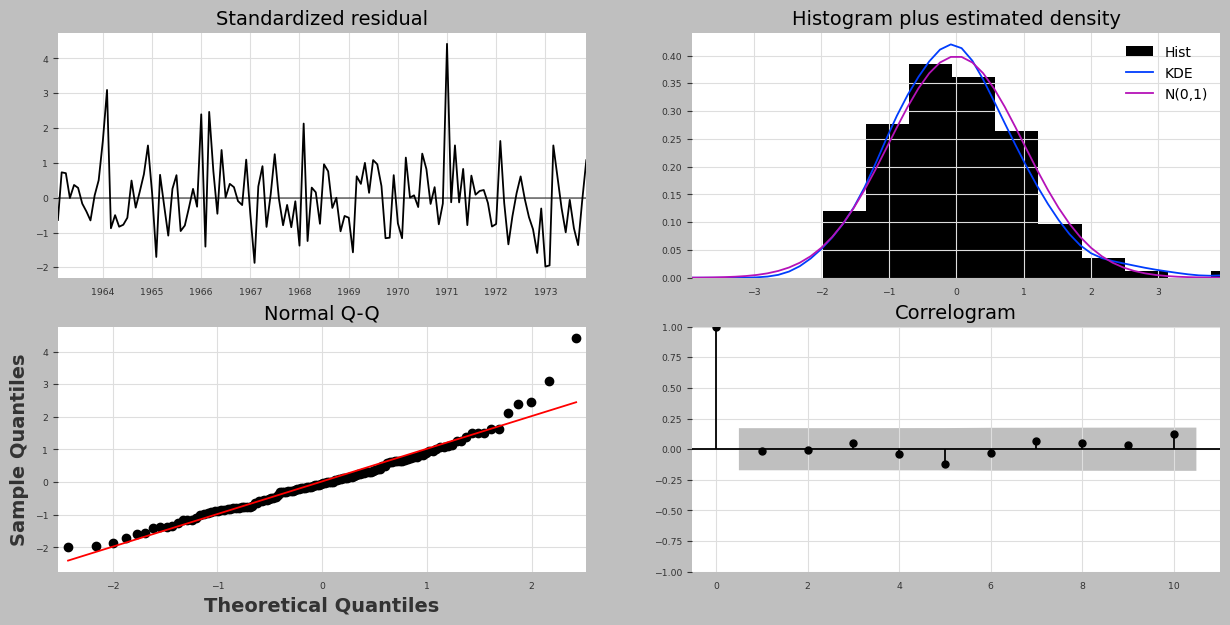

In [154]:
model.plot_diagnostics(figsize=(15,7));

In [23]:
# !pip install "u8darts[all]"

In [24]:
from darts.models import AutoARIMA
from darts import TimeSeries

### Using Darts AutoARIMA

In [25]:
model = AutoARIMA(seasonal=True, 
                           m=12,
                 stepwise=True)

In [26]:
ts = TimeSeries.from_dataframe(milk_train.reset_index(), 
                                    time_col='month', value_cols='production', freq='MS')

In [27]:
darts_arima = model.fit(ts)

In [44]:
darts_arima.model.model_.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (3, 0, 1),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 1, 1, 12),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': True}

In [43]:
darts_arima.model.model_

ARIMA(order=(3, 0, 1), scoring_args={}, seasonal_order=(0, 1, 1, 12),
      suppress_warnings=True)

In [31]:
darts_forecast = model.predict(len(milk_test))
darts_forecast.values()

array([[800.3198432 ],
       [826.62722968],
       [788.49568949],
       [889.73659536],
       [907.23139098],
       [968.90468532],
       [941.69387443],
       [899.14911166],
       [860.40277521],
       [814.30427778],
       [820.92620415],
       [786.669262  ],
       [826.99853092],
       [853.13968688],
       [814.19464578],
       [915.50913924],
       [932.2816702 ],
       [993.98180139],
       [966.1980917 ],
       [923.62864204],
       [884.43116053],
       [838.27497672],
       [844.53917104],
       [810.20641627],
       [850.24953325]])

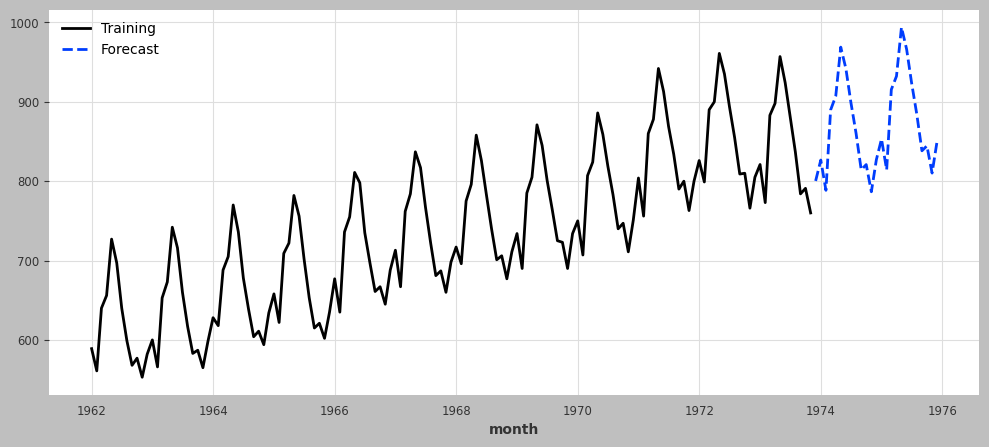

In [32]:
ts.plot(label='Training')
darts_forecast.plot(label='Forecast', linestyle='--');

### Using Darts StatsForecastAutoARIMA

In [46]:
from darts.models import StatsForecastAutoARIMA

In [47]:
model = StatsForecastAutoARIMA(season_length=12)
model.fit(ts)
pred = model.predict(len(milk_test))

In [57]:
model.model.model_.get('arma')

(1, 1, 0, 1, 12, 0, 1)

In [48]:
pred.values()

array([[796.82007579],
       [821.66956123],
       [780.65569931],
       [881.16500131],
       [896.16959827],
       [956.92979624],
       [927.63694517],
       [884.28054611],
       [843.82938372],
       [796.73423723],
       [801.96287665],
       [766.83537512],
       [804.683155  ],
       [829.48018084],
       [788.41420931],
       [888.87174937],
       [903.82492971],
       [964.5340541 ],
       [935.19047019],
       [891.78367676],
       [851.28245622],
       [804.13758554],
       [809.31683252],
       [774.14026808],
       [811.93931237]])

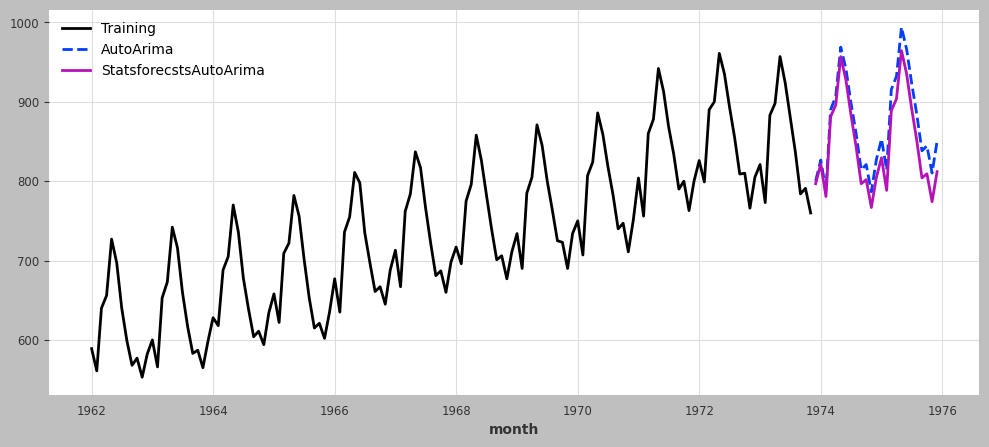

In [49]:
ts.plot(label='Training')
darts_forecast.plot(label='AutoArima', linestyle='--');
pred.plot(label='StatsforecstsAutoArima');